# Advanced Regression Assignment

Author: Sudarshan (sudarshan_g@outlook.com) <br>
Date Created: 13th September 2023 <br>
`View notebook on VSCode to navigate easily via Outline` <br>

## Problem Statement

### Assignment part - I

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.
 
The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
 
The company wants to know:
- `Which variables are significant in predicting the price of a house?`, and
- `How well those variables describe the price of a house?`.
- Also, `determine the optimal value of lambda for ridge and lasso regression.`

**Business Goal**

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

### Imports, Warning supression

In [1]:
## Import libraries.

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Data Understanding, Preparation and EDA

Let's prepare the data and import it properly as per the data definition

In [2]:
housing_au_df = pd.read_csv("./train.csv")
housing_au_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
housing_au_df.shape

(1460, 81)

In [4]:
# Data definition
print(open("./data_description.txt", "r").read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Tranforming as per data definition

Some of the features above have actual values as `NA` (No Alley, No Garage, No Fireplace etc.) which will be incorrectly interepreted by Pandas as missing values (`NaN`). So we would instruct Pandas to treat a `NA` as actual value and not a missing value.

In [5]:
housing_au_df = pd.read_csv("./train.csv", keep_default_na=False)
housing_au_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


Now we can see that `Alley` column values that were being recognized as `NaN` by Pandas are now just `NA`.
Let's replace these values across the features with `None`.

These are the columns that have NA as a defined value as per the data definition. 

- `Alley` (NA => No Alley)
- `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2` (NA => No Basement)
- `FireplaceQu` (NA => No Fireplace)
- `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond` (NA => No Garage)
- `PoolQC`: This is 99% NA (as in No Pool) and has been dropped from the dataset. 
- `Fence`: This is 80% NA (as in No Fence) and has been dropped from the dataset.
- `MiscFeature`: NA => None.    

Instead of keeping different values for different `NA` value in each feature. We will collectively replace it with `None`

In [6]:
NA_features = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
housing_au_df[NA_features] = housing_au_df[NA_features].replace("NA", "None")
housing_au_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [7]:
# MSSubClass, OverallQual, OverallCond are pseudo-numerics, they are actually categories/ratings out of 10. 
# Therfore, changing it to object type. 

housing_au_df.MSSubClass = housing_au_df.MSSubClass.astype('object')
housing_au_df.OverallQual = housing_au_df.OverallQual.astype('object')
housing_au_df.OverallCond = housing_au_df.OverallCond.astype('object')

housing_au_df.LotFrontage = pd.to_numeric(housing_au_df.LotFrontage, errors='coerce') ## Linear feet of street connected to property.
housing_au_df.MasVnrArea = pd.to_numeric(housing_au_df.MasVnrArea, errors='coerce') ## Masonry Veneer Area in Sq.Ft

In [8]:
### Examining mean-median variance across numeric columns.
with pd.option_context('display.max_columns', housing_au_df.shape[1]):
    print(housing_au_df.describe())

                Id  LotFrontage        LotArea    YearBuilt  YearRemodAdd  \
count  1460.000000  1201.000000    1460.000000  1460.000000   1460.000000   
mean    730.500000    70.049958   10516.828082  1971.267808   1984.865753   
std     421.610009    24.284752    9981.264932    30.202904     20.645407   
min       1.000000    21.000000    1300.000000  1872.000000   1950.000000   
25%     365.750000    59.000000    7553.500000  1954.000000   1967.000000   
50%     730.500000    69.000000    9478.500000  1973.000000   1994.000000   
75%    1095.250000    80.000000   11601.500000  2000.000000   2004.000000   
max    1460.000000   313.000000  215245.000000  2010.000000   2010.000000   

        MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  \
count  1452.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    103.685262   443.639726    46.549315   567.240411  1057.429452   
std     181.066207   456.098091   161.319273   441.866955   438.705324   
min       

We can see that for some of the features, the variance between mean and median is enormous.
Specifically - `2ndFlrSF`, `MiscVal`, `PoolArea`, `ScreenPorch`. Let's plot them. 

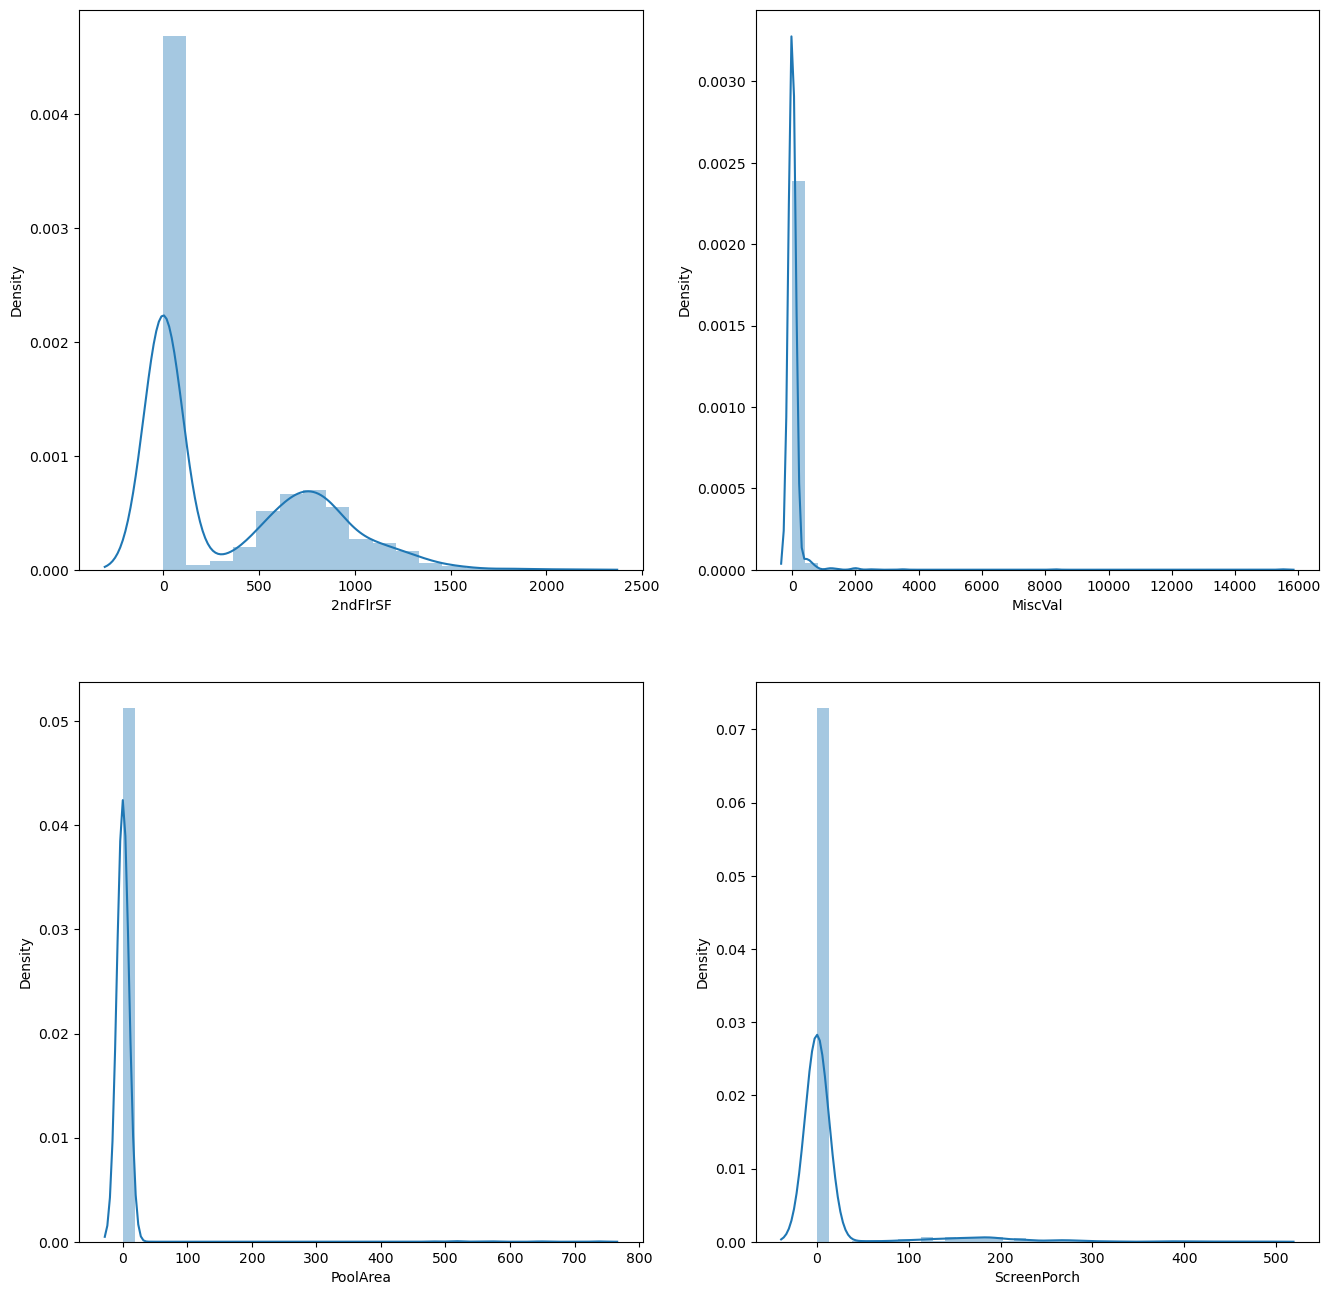

In [9]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
sns.distplot(housing_au_df['2ndFlrSF'])
plt.subplot(2,2,2)
sns.distplot(housing_au_df['MiscVal'])
plt.subplot(2,2,3)
sns.distplot(housing_au_df['PoolArea'])
plt.subplot(2,2,4)
sns.distplot(housing_au_df['ScreenPorch'])
plt.show()

In [10]:
# Let's drop PoolArea, MiscVal and ScreenPorch from the dataset as these are 99% 0. 
housing_au_df.drop(['MiscVal', 'PoolArea', 'ScreenPorch'], axis=1, inplace=True)

`Findings/Observations`: 
- `Alley` `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `FireplaceQu`,`GarageType`, `GarageFinish`, `GarageQual`, `GarageCond` <br>
All of these variables had `NA` as an actual value. `keep_default_na` was specified as `False` while importing to not treat them as missing values.
- `PoolQC`: This is 99% NA (as in No Pool) and has been dropped from the dataset. 
- `Fence`: This is 80% NA (as in No Fence) and has been dropped from the dataset.
- `MiscFeature`: NA => None. 
- Missing values in `LotFrontage` and `MasVnrArea` were imputed using median value.
- `MiscVal`, `PoolArea` and `ScreenPorch` were dropped as they were mostly `0`.

### Checking for duplicates


In [11]:
housing_au_df_1 = housing_au_df.copy()
housing_au_df_1.drop_duplicates(inplace=True)
housing_au_df_1.shape


(1460, 78)

`Findings/Observations:` Same shape after dropping duplicates, therefore we don't have any duplicates

### Checking for Null values

In [12]:
## Now that the data is fixed and adjusted as per the appropriate types, let's check nulls.
((housing_au_df.isna().sum()/housing_au_df.isna().count()) * 100).sort_values(ascending=False).head(10)

LotFrontage     17.739726
MasVnrArea       0.547945
Id               0.000000
HalfBath         0.000000
Fireplaces       0.000000
Functional       0.000000
TotRmsAbvGrd     0.000000
KitchenQual      0.000000
KitchenAbvGr     0.000000
BedroomAbvGr     0.000000
dtype: float64

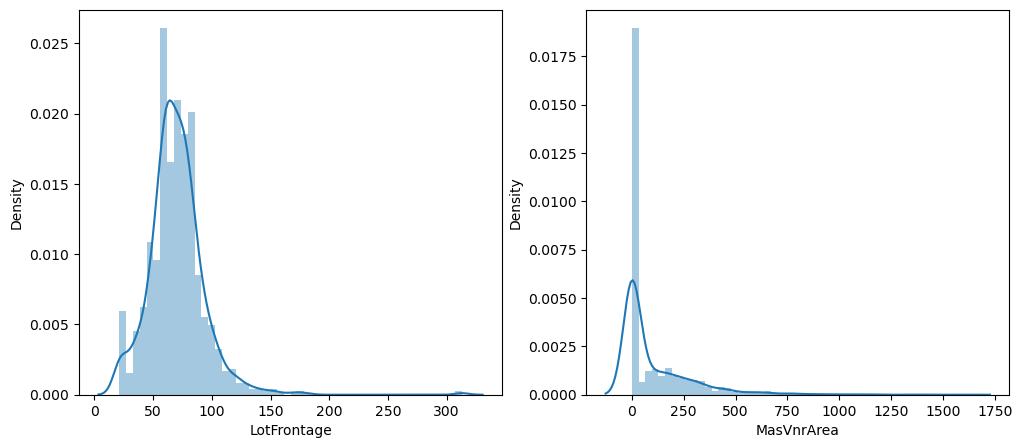

In [13]:
# LotFrontage & MasVnrArea area numerical and the only ones that have null values. Let's plot them.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.distplot(housing_au_df.LotFrontage)
plt.subplot(1,2,2)
sns.distplot(housing_au_df.MasVnrArea)
plt.show()

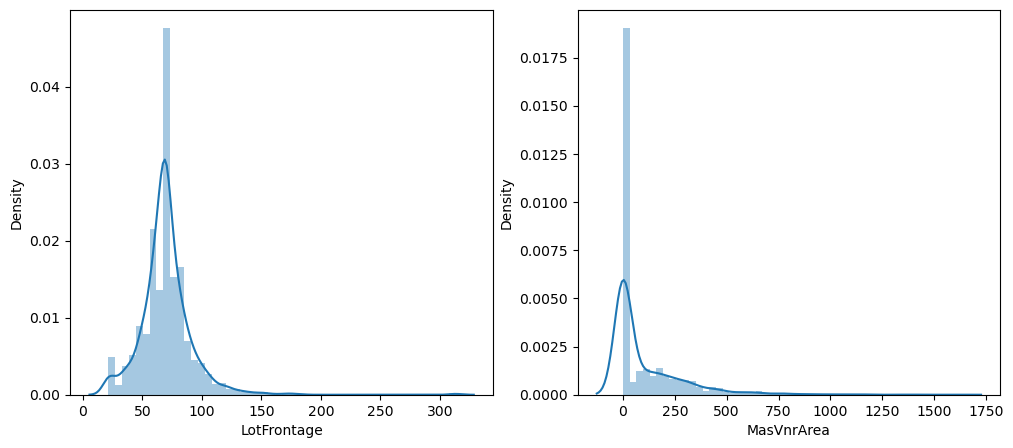

In [14]:
# Let's impute the missing items with median and then check the plot again.
housing_au_df.LotFrontage.fillna(housing_au_df.LotFrontage.median(), inplace=True)
housing_au_df.MasVnrArea.fillna(housing_au_df.MasVnrArea.median(), inplace=True)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.distplot(housing_au_df.LotFrontage)
plt.subplot(1,2,2)
sns.distplot(housing_au_df.MasVnrArea)
plt.show()

In [15]:
housing_au_df.isnull().sum().sort_values(ascending=False)

Id              0
FullBath        0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
               ..
MasVnrType      0
Exterior2nd     0
Exterior1st     0
RoofMatl        0
SalePrice       0
Length: 78, dtype: int64

`Findings/Observations`: We found null values within `LotFrontage` and `MasVnrArea` and these were imputed using the median.

### Deriving variables

In [16]:
pd.to_numeric(housing_au_df['GarageYrBlt'], errors='coerce')

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
         ...  
1455    1999.0
1456    1978.0
1457    1941.0
1458    1950.0
1459    1965.0
Name: GarageYrBlt, Length: 1460, dtype: float64

In [17]:
## Computing new variables from the YearBuilt, YrSold and YearRemodAdd. 
## We will drop the actuals after the new variables are added in. 

import datetime
housing_au_df['Age_at_Sale'] = housing_au_df['YrSold'] - housing_au_df['YearBuilt']
housing_au_df['RemodAge'] = datetime.date.today().year - housing_au_df['YearRemodAdd'].astype('int')
housing_au_df['GarageAge'] = datetime.date.today().year - pd.to_numeric(housing_au_df['GarageYrBlt'], errors='coerce')
housing_au_df['GarageAge'].fillna(0, inplace=True)
housing_au_df.drop(['YearRemodAdd','YrSold', 'YearBuilt', 'GarageYrBlt'], axis=1, inplace=True)


`Findings/Observations:`

- Derived 3 variables - `Age_at_Sale`, `RemodAge` and `GarageAge` using the variables `YearBuilt`, `YearRemodAdd`, `YrSold` and `GarageYrBlt`
- Dropped variables  `YearBuilt`, `YearRemodAdd`, `YrSold` and `GarageYrBlt`

### Handling Outliers & heavily skewed features

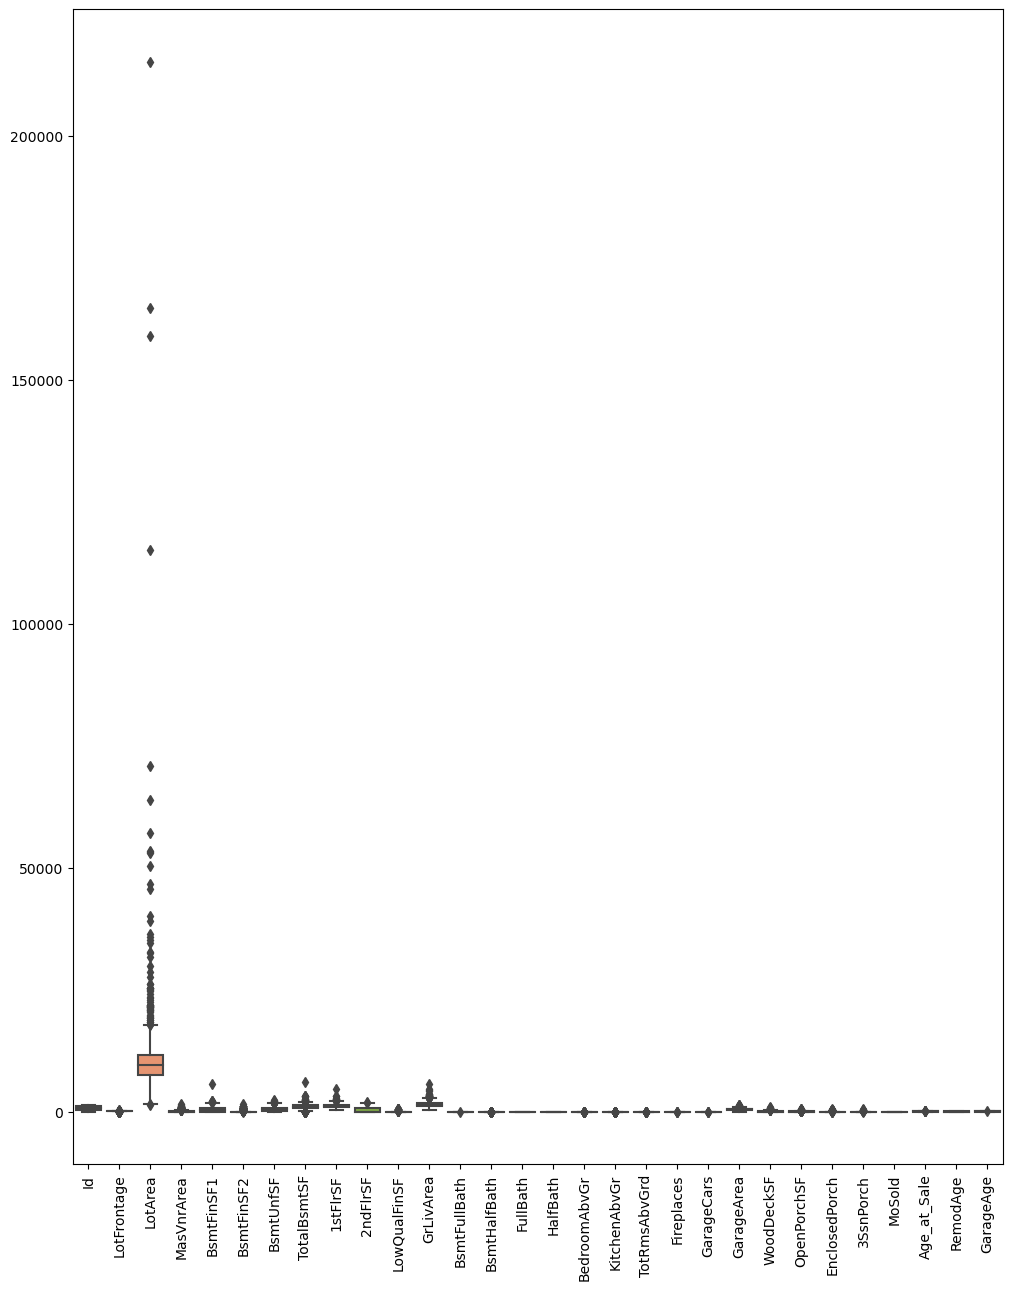

In [18]:
## Our target variable is sale price, 
## we will take exclude this from the dataset for now to better fit the scale and 
## identify outliers in the other features easily.

plt.figure(figsize=(12,15))
plt.xticks(rotation=90)
sns.boxplot(data=housing_au_df.select_dtypes(include='number').drop('SalePrice', axis=1))
plt.show()

In [19]:
## Let's check the kurtosis for each feature to see which ones are heavily affected by outliers. 
## As a good measure we will be keeping all of the features between 5% and 95% quantiles.

housing_au_df.select_dtypes(include='number').drop('SalePrice', axis=1).kurtosis()

Id                -1.200000
LotFrontage       21.912954
LotArea          203.243271
MasVnrArea        10.141416
BsmtFinSF1        11.118236
BsmtFinSF2        20.113338
BsmtUnfSF          0.474994
TotalBsmtSF       13.250483
1stFlrSF           5.745841
2ndFlrSF          -0.553464
LowQualFinSF      83.234817
GrLivArea          4.895121
BsmtFullBath      -0.839098
BsmtHalfBath      16.396642
FullBath          -0.857043
HalfBath          -1.076927
BedroomAbvGr       2.230875
KitchenAbvGr      21.532404
TotRmsAbvGrd       0.880762
Fireplaces        -0.217237
GarageCars         0.220998
GarageArea         0.917067
WoodDeckSF         2.992951
OpenPorchSF        8.490336
EnclosedPorch     10.430766
3SsnPorch        123.662379
MoSold            -0.404109
Age_at_Sale       -0.436829
RemodAge          -1.272245
GarageAge         -0.419309
dtype: float64

In [20]:
## Capping outliers to 5% on lower end and 95% on higher end. 

for feature in housing_au_df.select_dtypes(include='number').drop('SalePrice', axis=1).columns:
    housing_au_df[feature][housing_au_df[feature] <= housing_au_df[feature].quantile(0.05)] = housing_au_df[feature].quantile(0.05)
    housing_au_df[feature][housing_au_df[feature] >= housing_au_df[feature].quantile(0.95)] = housing_au_df[feature].quantile(0.95)

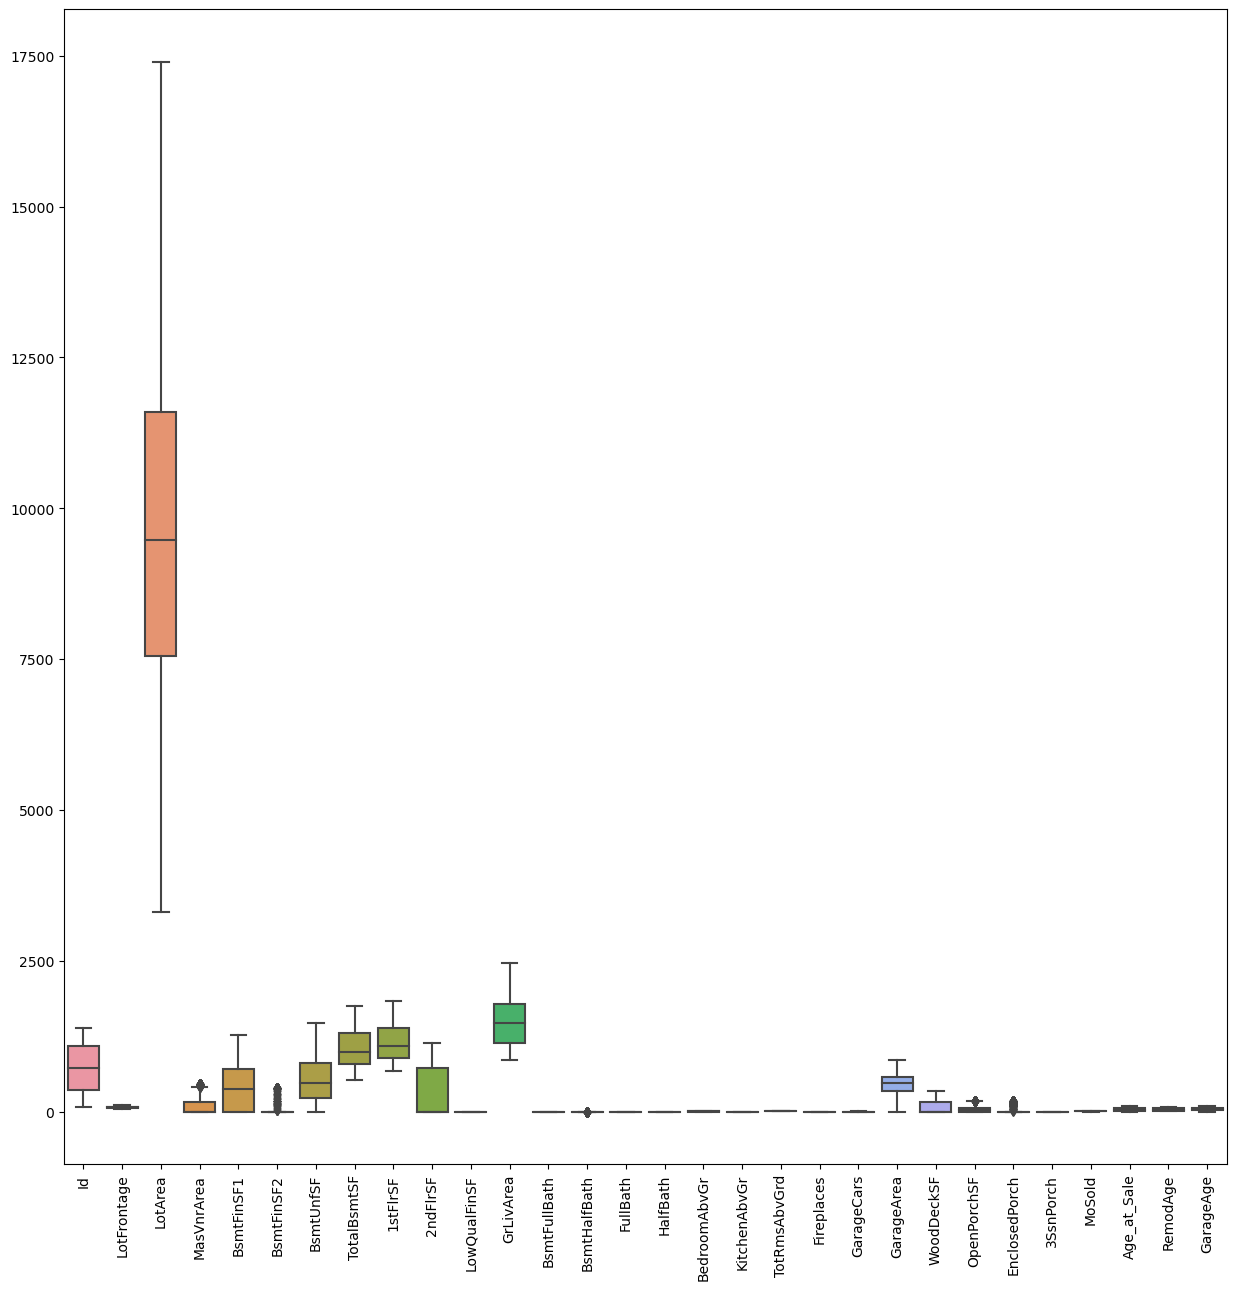

In [21]:
## Plotting it once again 

plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.boxplot(data=housing_au_df.select_dtypes(include='number').drop('SalePrice', axis=1))
plt.show()

In [22]:
## Checking kurtosis once again for everything including SalePrice
housing_au_df.select_dtypes(include='number').kurtosis().sort_values(ascending=False)

BsmtHalfBath     12.912670
BsmtFinSF2        7.506432
SalePrice         6.536282
EnclosedPorch     4.460905
MasVnrArea        0.695359
OpenPorchSF       0.292329
GarageCars        0.095310
GarageArea        0.053422
LowQualFinSF      0.000000
KitchenAbvGr      0.000000
3SsnPorch         0.000000
LotFrontage      -0.047847
LotArea          -0.100212
TotRmsAbvGrd     -0.223461
BsmtUnfSF        -0.447314
WoodDeckSF       -0.544709
GrLivArea        -0.565859
Fireplaces       -0.633778
MoSold           -0.687571
TotalBsmtSF      -0.722731
BedroomAbvGr     -0.727142
1stFlrSF         -0.784506
GarageAge        -0.814229
BsmtFinSF1       -0.886205
Age_at_Sale      -0.972792
2ndFlrSF         -1.234479
Id               -1.250686
RemodAge         -1.271962
HalfBath         -1.733597
BsmtFullBath     -1.879498
FullBath         -1.964415
dtype: float64

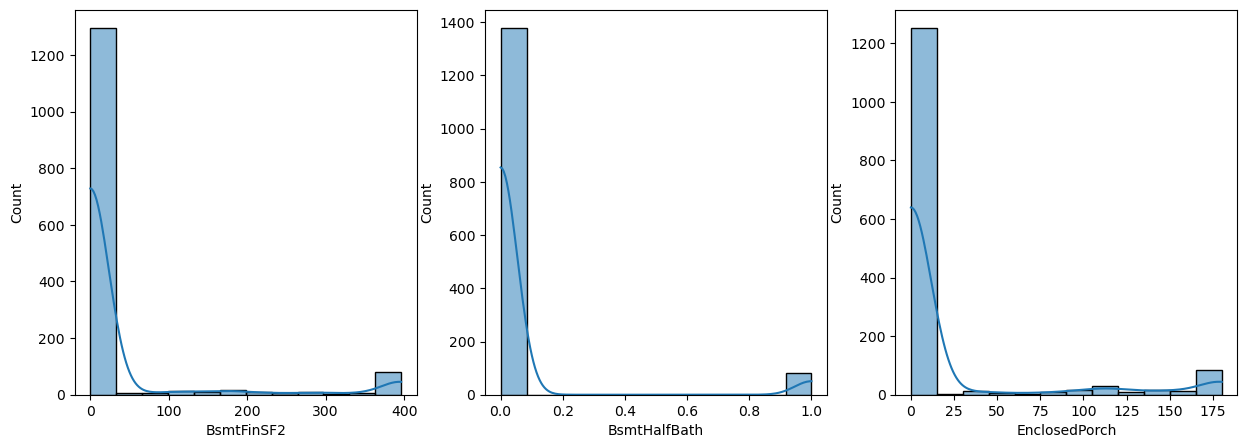

In [23]:
# From the above output we can still see that `BsmtHalfBath` and `BsmtFinSF2` still have high kurtosis values. 
# Let's examine their plots.

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.histplot(data=housing_au_df['BsmtFinSF2'], kde=True) ## Type 2 finished square feet
plt.subplot(1,3,2)
sns.histplot(data=housing_au_df['BsmtHalfBath'], kde=True) ## Basement half bathrooms
plt.subplot(1,3,3)
sns.histplot(data=housing_au_df['EnclosedPorch'], kde=True) ## Enclosed porch area in square feet
plt.show()

In [24]:
# We can see that majority of the values within these 3 features are 0. Infact more than 85% of values are 0 in both the features.
# Most homes don't have a Bsmt Finished Sq Ft, Basement half bathrooms or enclosed porch areas. 
# More than 1200 out of 1460 homes fit this criteria.

housing_au_df[['BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch']].describe(percentiles=[0.25,0.5,0.75,0.85,0.9,0.95,0.98, 1.0])

,BsmtFinSF2,BsmtHalfBath,EnclosedPorch
count,1460.000000,1460.000000,1460.000000
mean,32.931233,0.056164,19.154075
std,100.569218,0.230318,50.385647
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
85%,0.000000,0.000000,0.000000
90%,117.200000,0.000000,112.000000
95%,396.010000,1.000000,180.007500


In [25]:
# Let's drop these features.
housing_au_df.drop(['BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch'], inplace=True, axis=1)

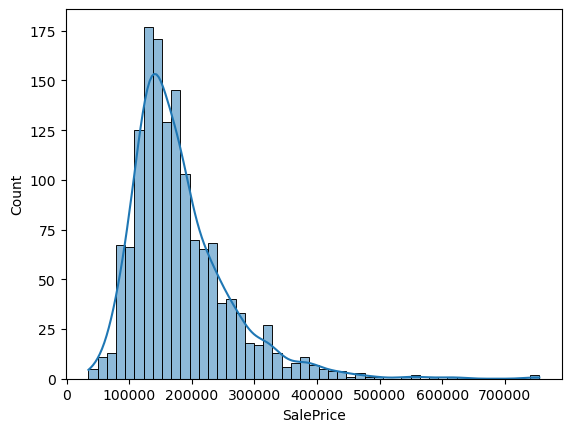

In [26]:
sns.histplot(data=housing_au_df['SalePrice'], kde=True)
plt.show()

In [27]:
## Keeping it between 0.02 to 0.98
housing_au_df['SalePrice'][housing_au_df['SalePrice'] <= housing_au_df['SalePrice'].quantile(0.02)] = housing_au_df['SalePrice'].quantile(0.02)
housing_au_df['SalePrice'][housing_au_df['SalePrice'] >= housing_au_df['SalePrice'].quantile(0.98)] = housing_au_df['SalePrice'].quantile(0.98)

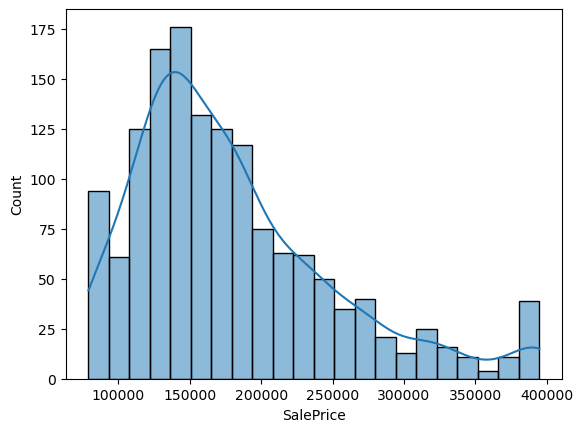

In [28]:
sns.histplot(housing_au_df['SalePrice'], kde=True)
plt.show()

In [29]:
## Checking kurtosis once again for everything including SalePrice
housing_au_df.select_dtypes(include='number').kurtosis().sort_values(ascending=False)

SalePrice       1.037936
MasVnrArea      0.695359
OpenPorchSF     0.292329
GarageCars      0.095310
GarageArea      0.053422
KitchenAbvGr    0.000000
3SsnPorch       0.000000
LowQualFinSF    0.000000
LotFrontage    -0.047847
LotArea        -0.100212
TotRmsAbvGrd   -0.223461
BsmtUnfSF      -0.447314
WoodDeckSF     -0.544709
GrLivArea      -0.565859
Fireplaces     -0.633778
MoSold         -0.687571
TotalBsmtSF    -0.722731
BedroomAbvGr   -0.727142
1stFlrSF       -0.784506
GarageAge      -0.814229
BsmtFinSF1     -0.886205
Age_at_Sale    -0.972792
2ndFlrSF       -1.234479
Id             -1.250686
RemodAge       -1.271962
HalfBath       -1.733597
BsmtFullBath   -1.879498
FullBath       -1.964415
dtype: float64

In [30]:
# Let's examine outliers within categorical variables.
housing_au_df_cat = housing_au_df.select_dtypes(include='object')
housing_au_df_cat.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

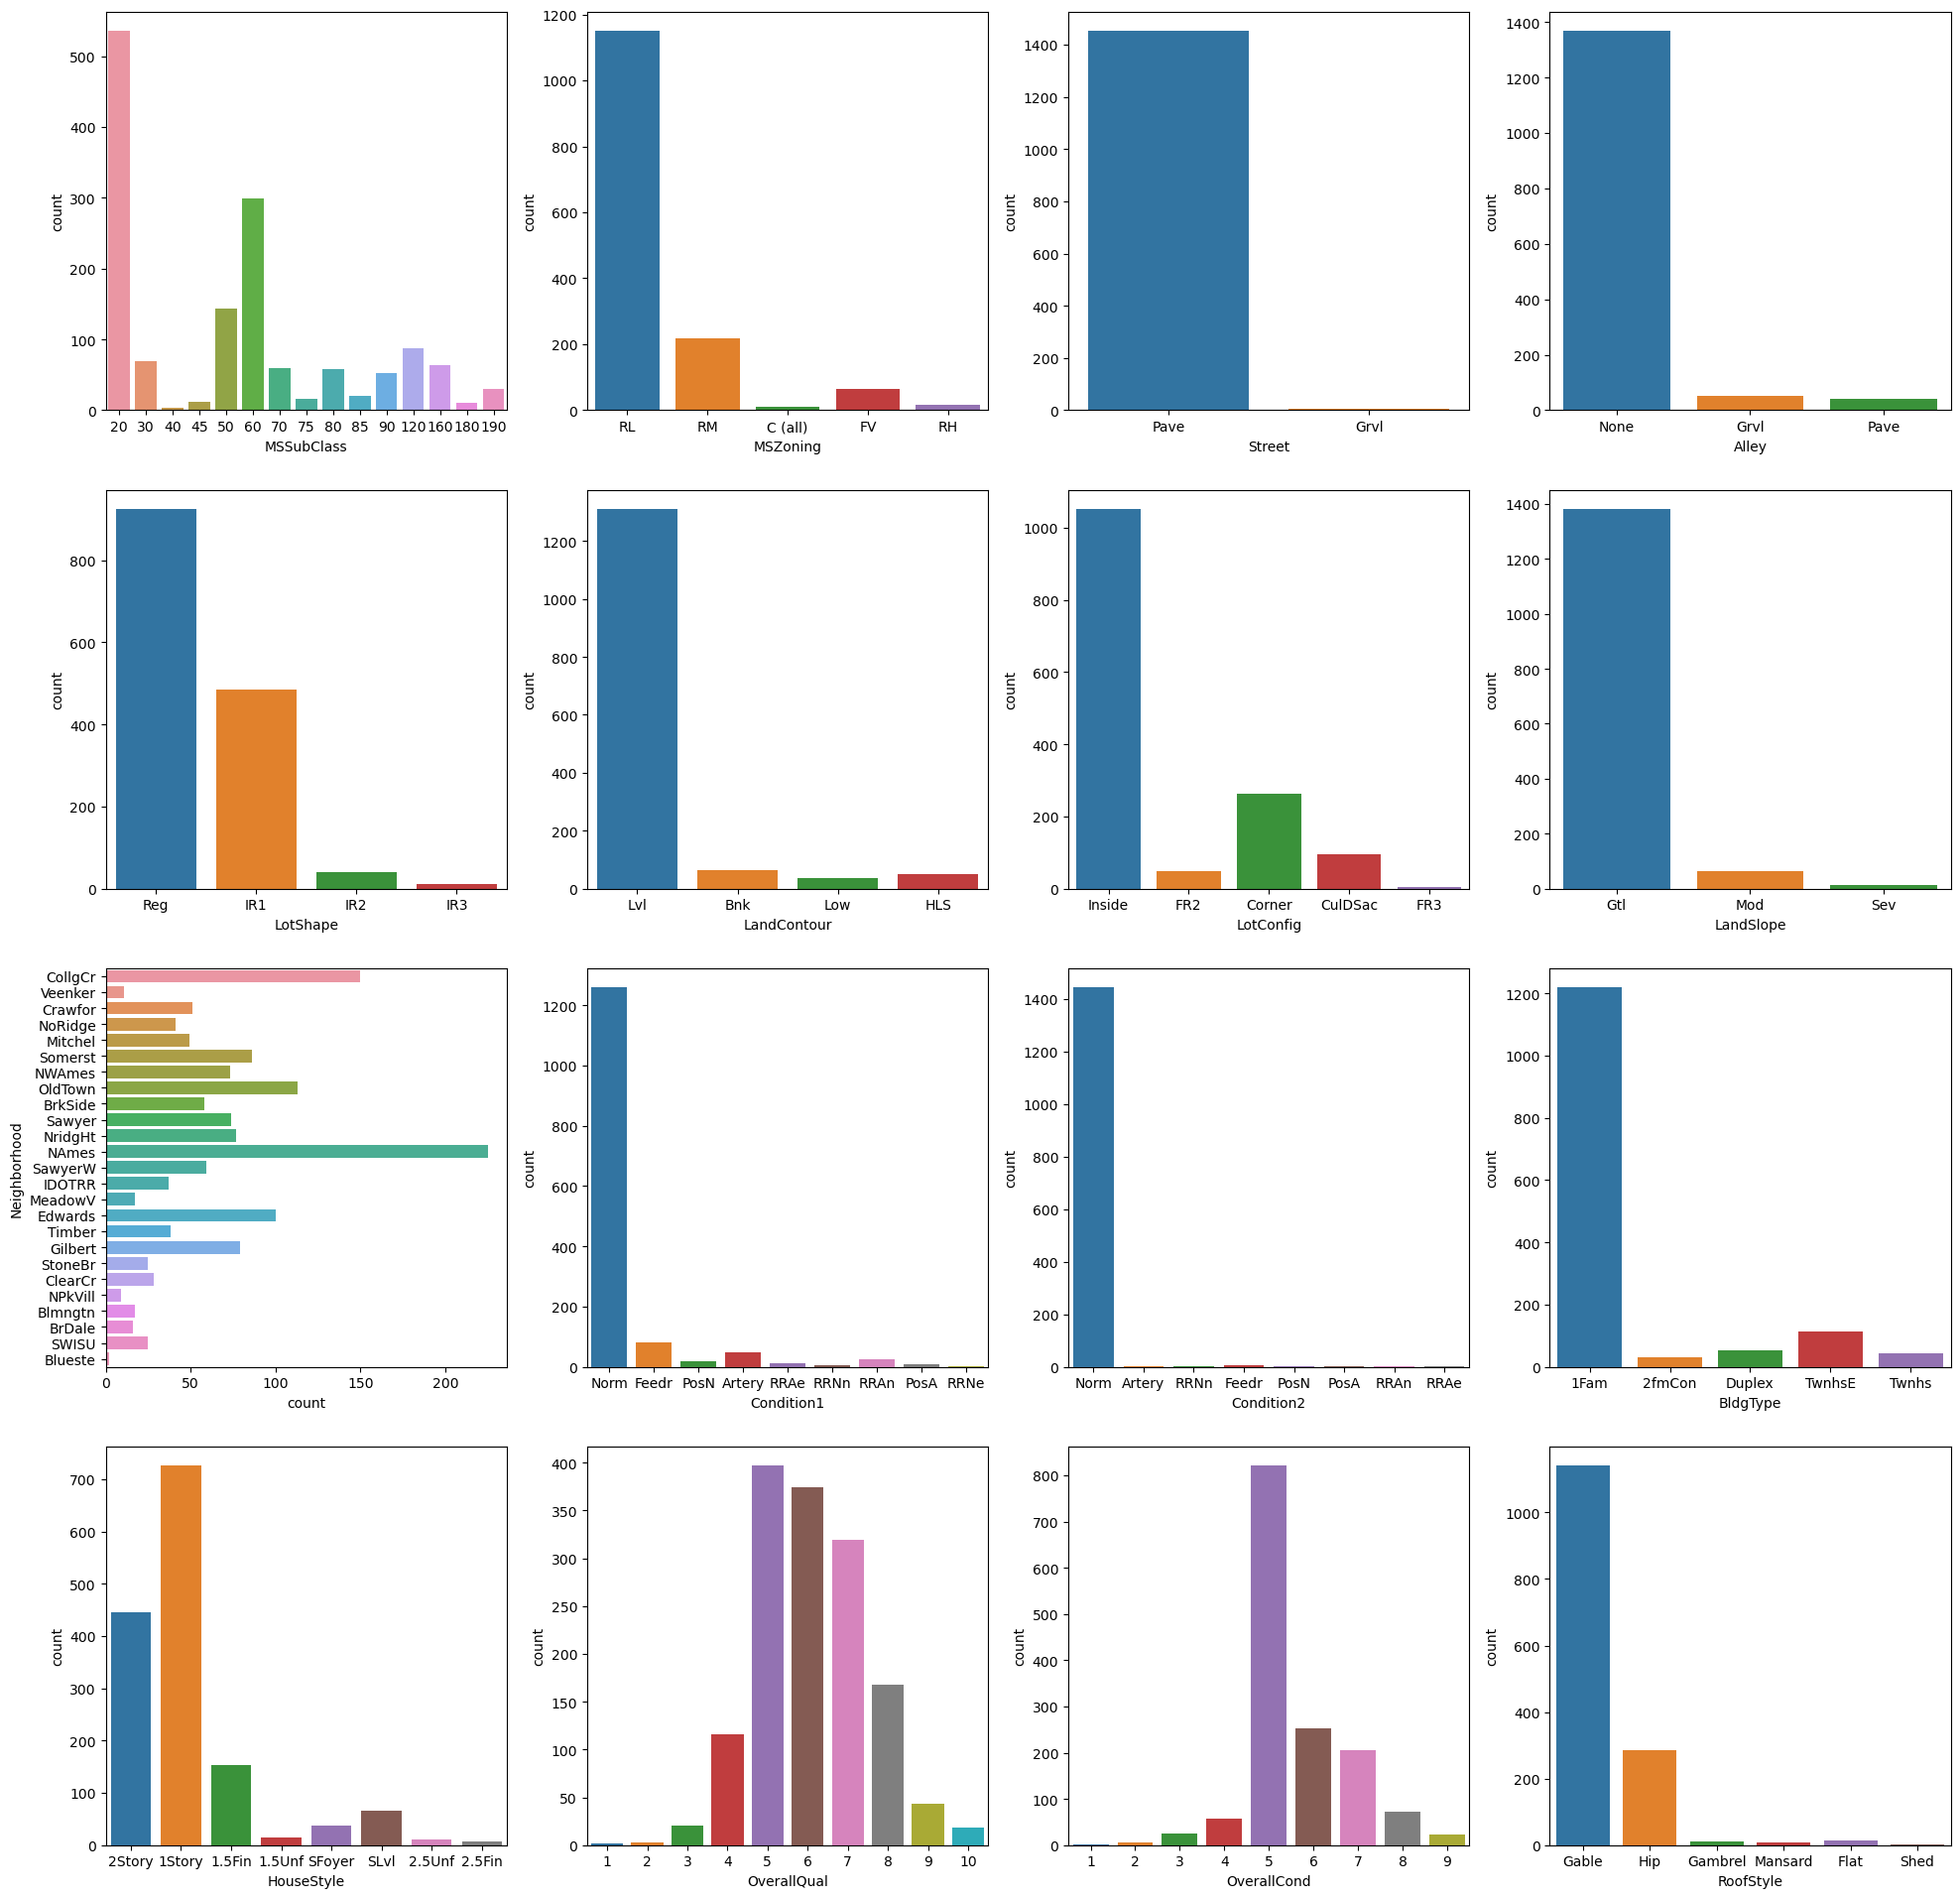

In [31]:
def plot_cat_columns(cat_columns, m, n):
    plt.figure(figsize=(m*6, n*6))
    i = 0;
    for col in cat_columns:
        i = i+1;
        plt.subplot(m, n, i);
        if col in ('Neighborhood', 'Exterior1st', 'Exterior2nd', 'RoofMatl'):
            sns.countplot(y=col, data=housing_au_df)
        else:
            sns.countplot(x = col, data=housing_au_df)

columns_set_A = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle']

plot_cat_columns(columns_set_A, 4,4)

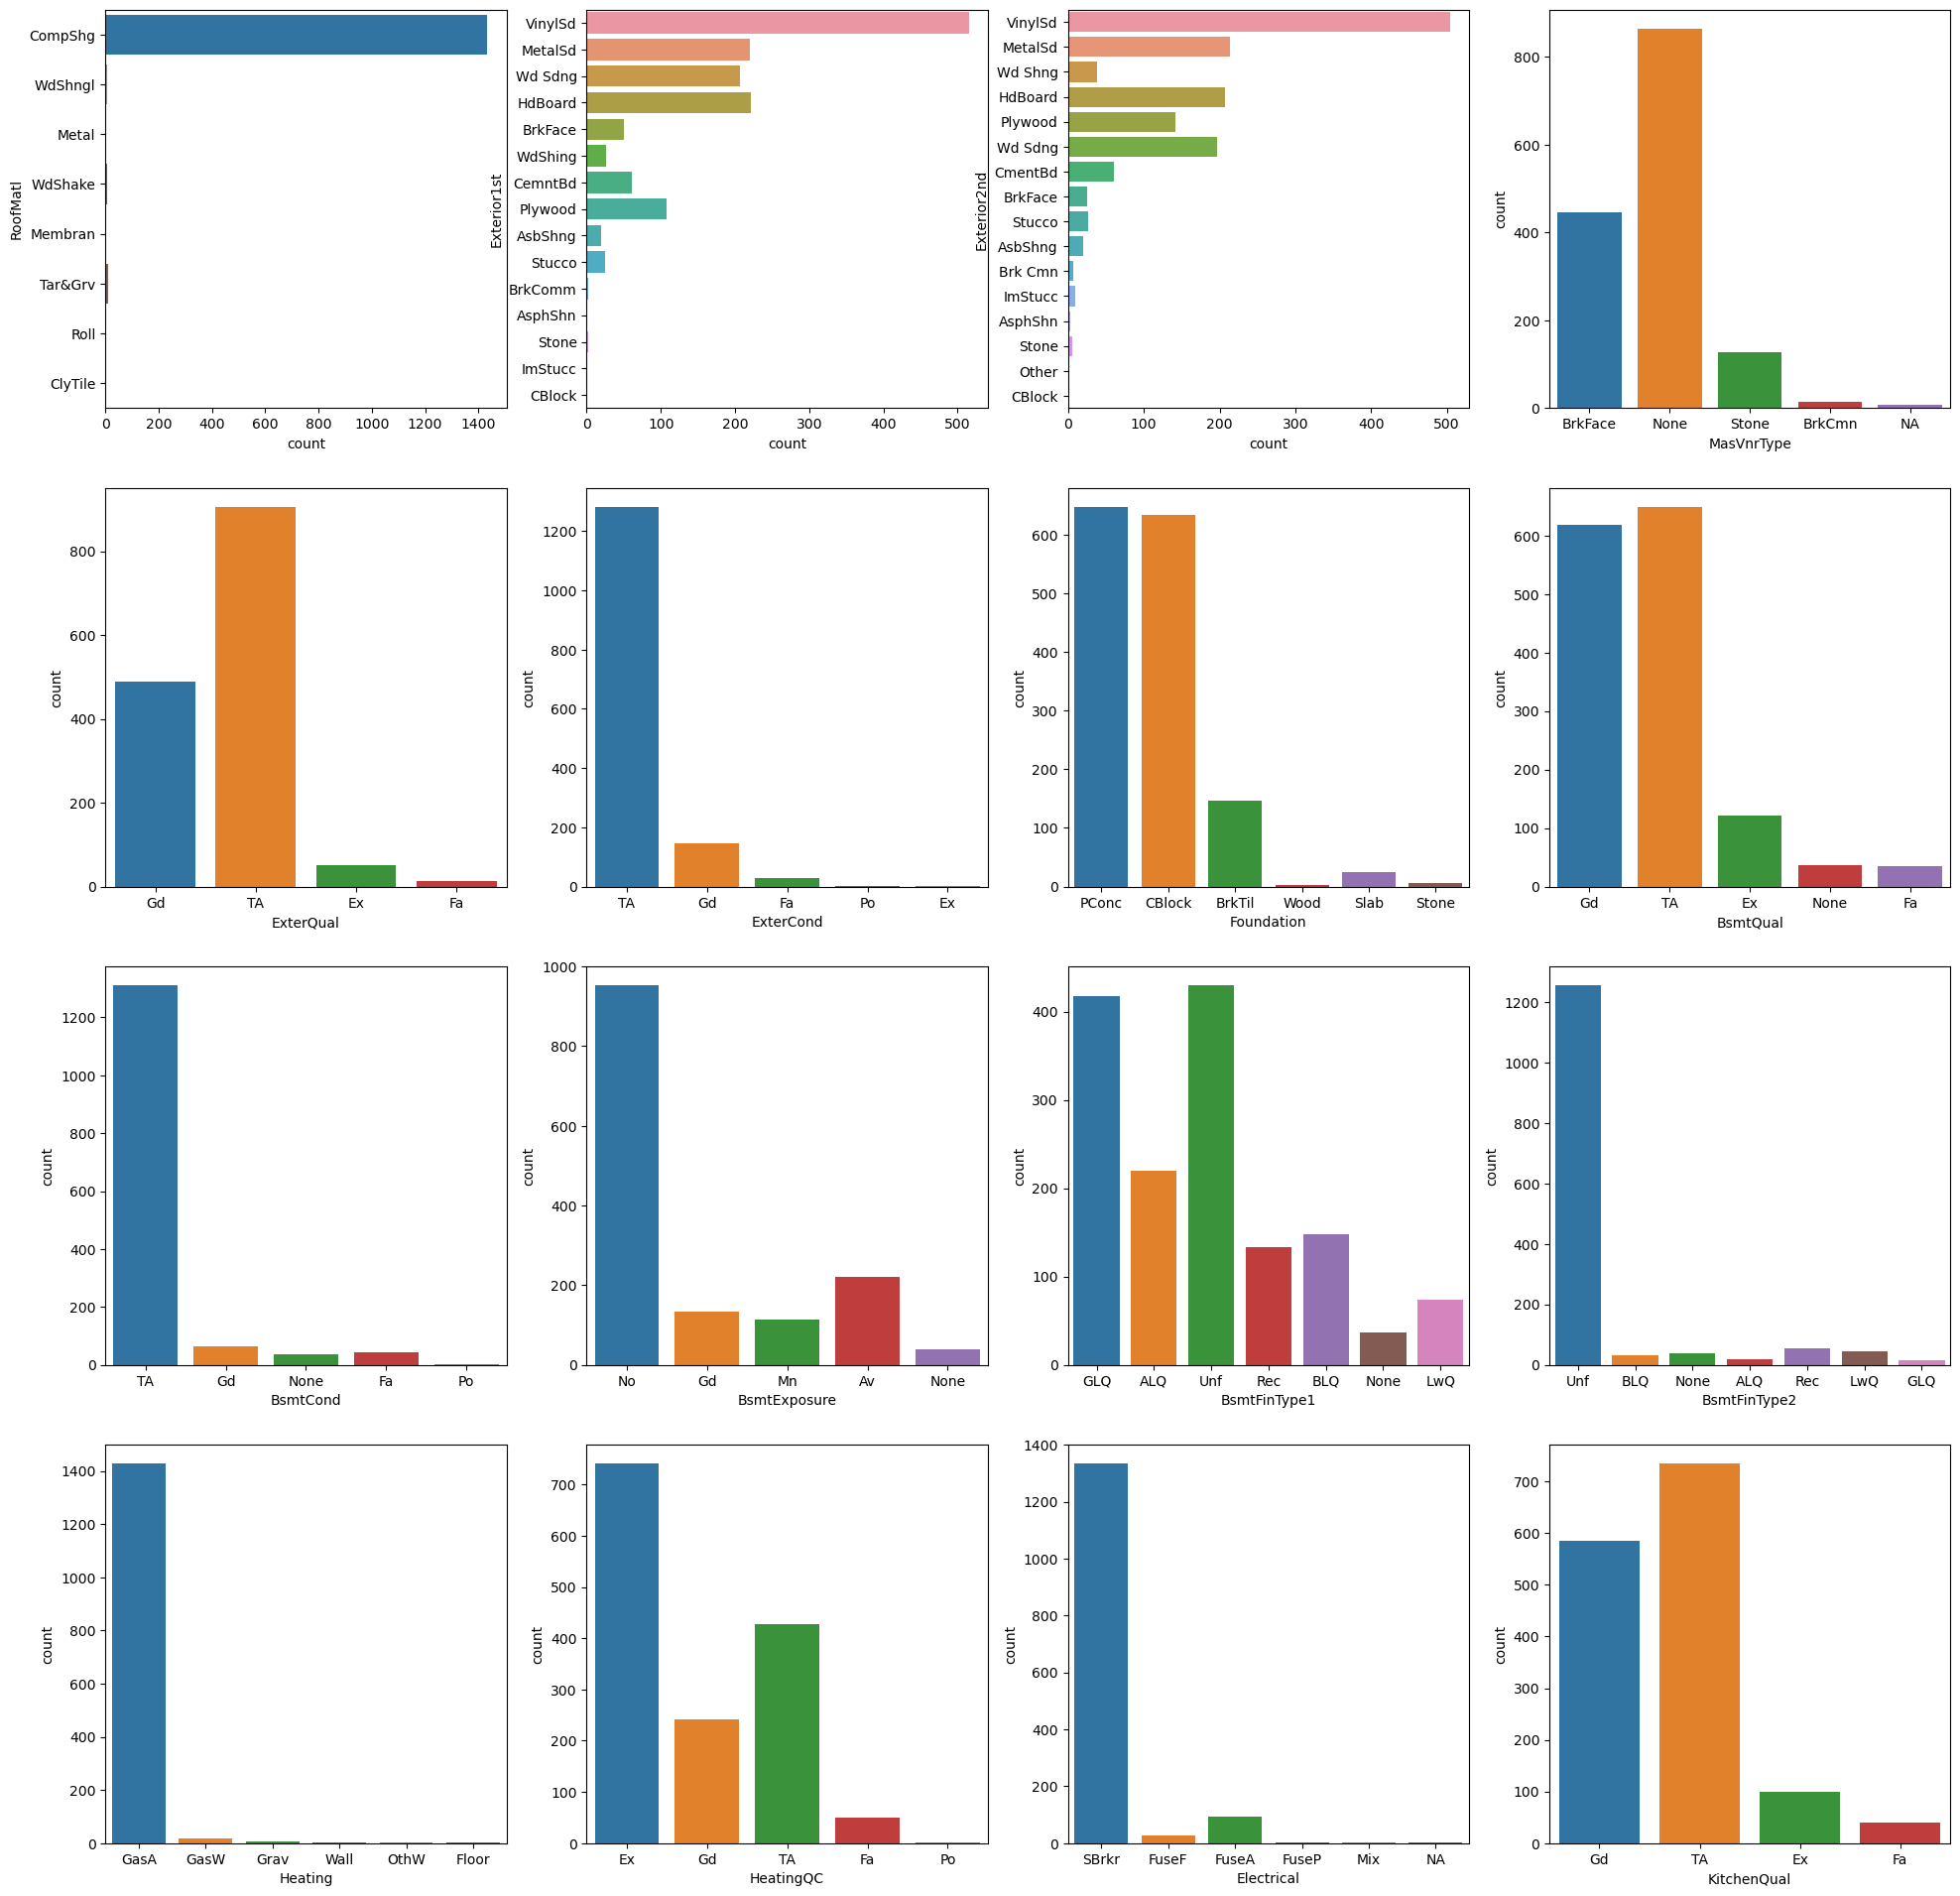

In [32]:
columns_set_B = ['RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual','ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 
]

plot_cat_columns(columns_set_B, 4,4)
#len(columns_set_II)

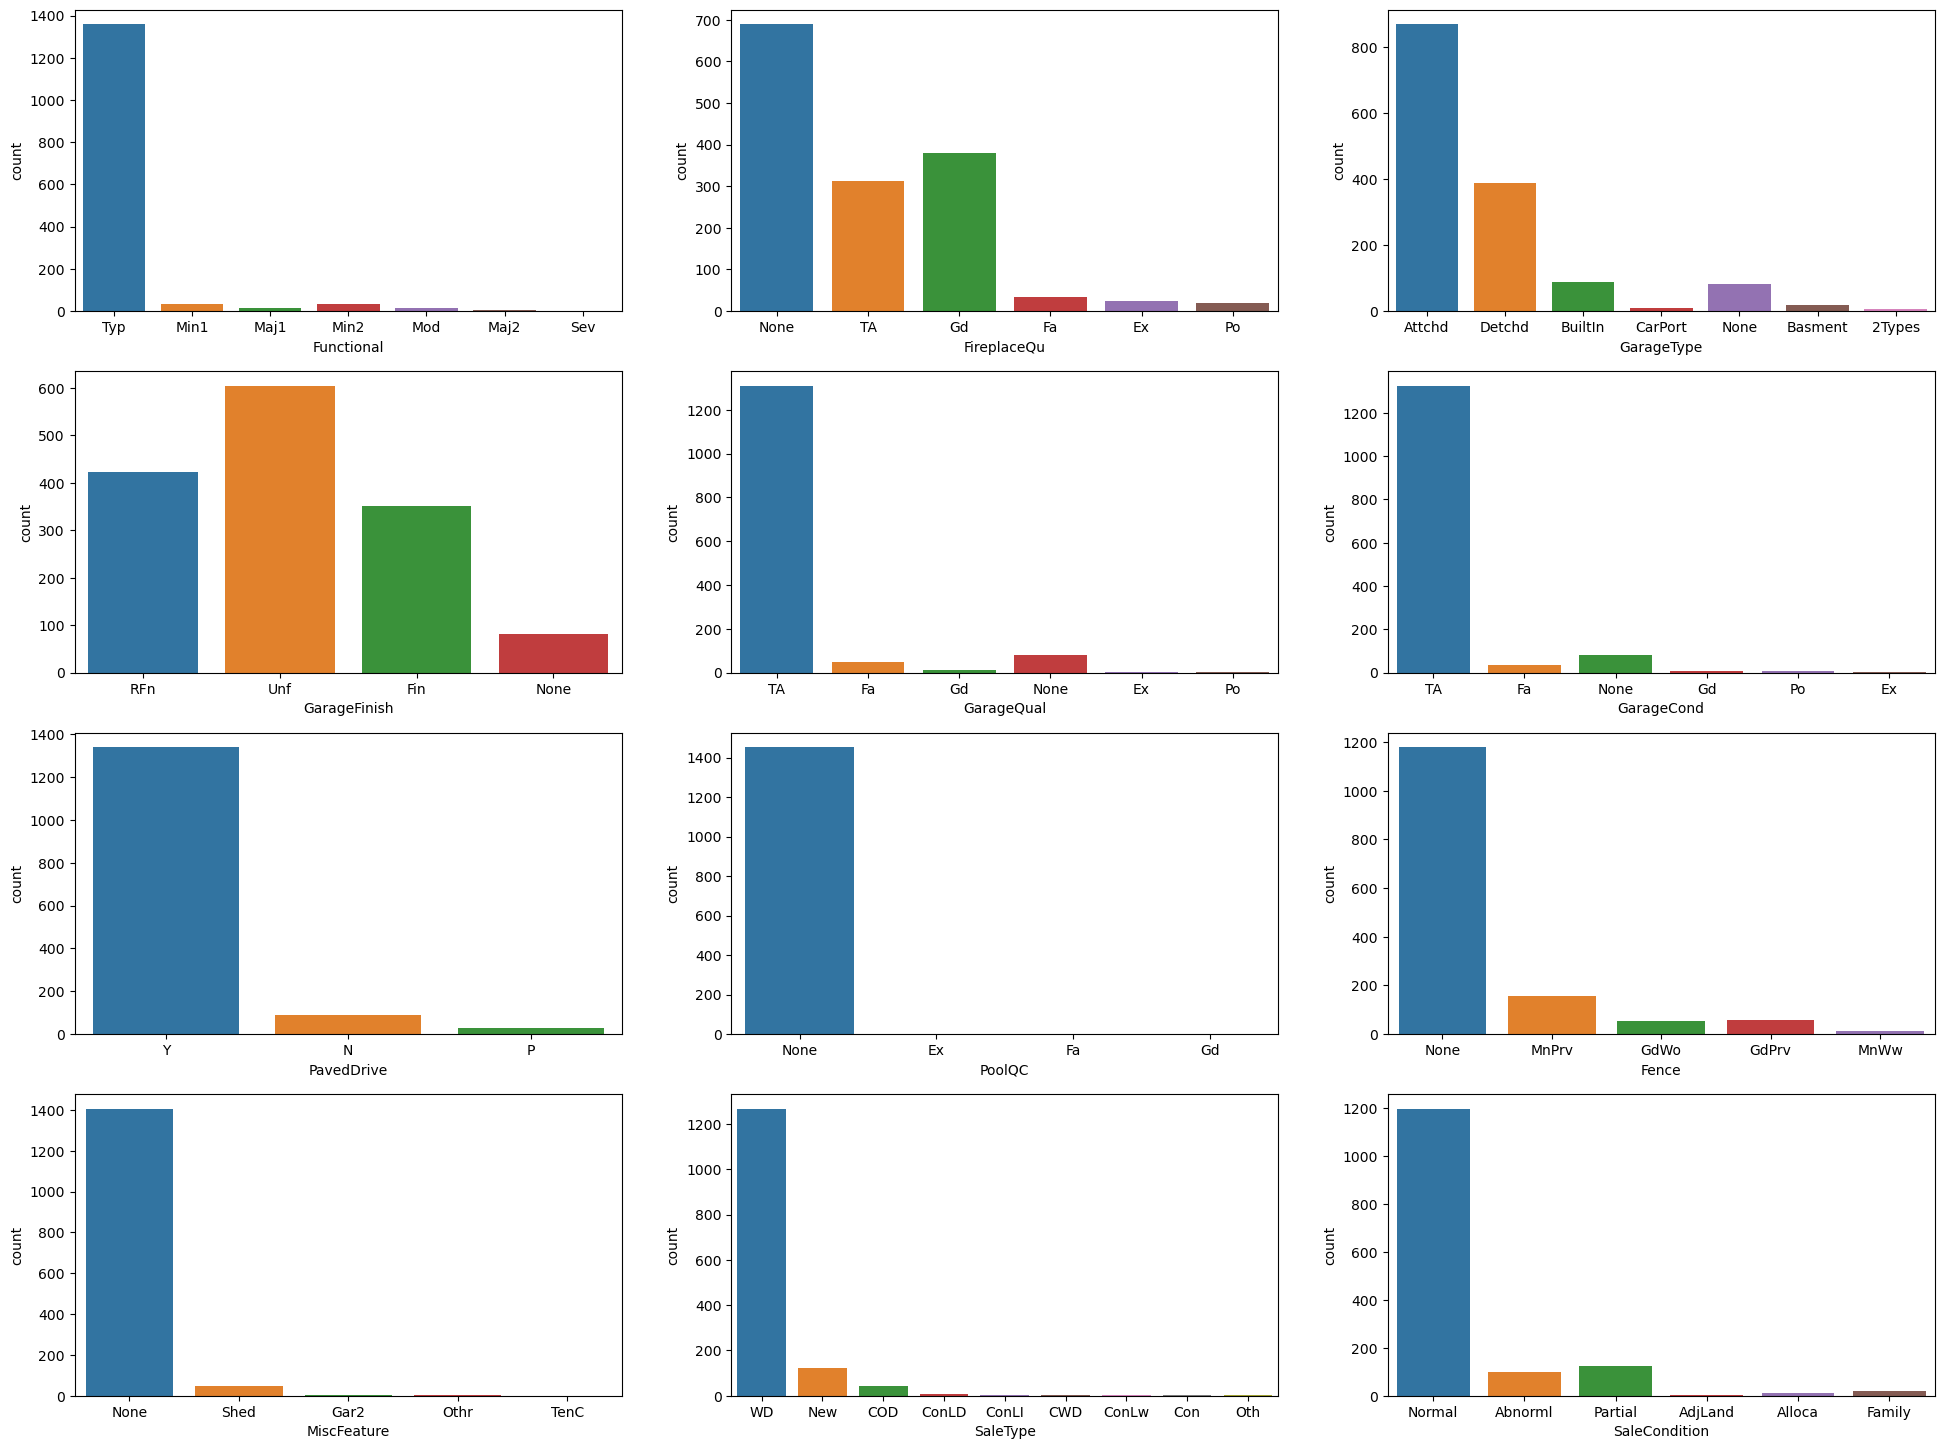

In [33]:
columns_set_C = ['Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
                 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
plot_cat_columns(columns_set_C, 4,3)

In [34]:
# Dropping the following columns as they are heavily skewed. More than ~85% records within 1 category. 
drop_list = ['MiscFeature', 'PoolQC', 'PavedDrive', 'GarageCond','GarageQual', 'Functional', 'Electrical', 'Heating', 'BsmtFinType2', 
             'BsmtCond', 'ExterCond', 'RoofMatl', 'Condition1', 'Condition2', 'LandContour', 'LandSlope', 'Alley', 'Street']

housing_au_df.drop(drop_list, axis=1, inplace=True)

In [35]:
#Final shape
housing_au_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,Utilities,LotConfig,Neighborhood,BldgType,...,OpenPorchSF,3SsnPorch,Fence,MoSold,SaleType,SaleCondition,SalePrice,Age_at_Sale,RemodAge,GarageAge
0,73.95,60,RL,65.0,8450.0,Reg,AllPub,Inside,CollgCr,1Fam,...,61.0,0,None,2,WD,Normal,208500.0,5,20,20.0
1,73.95,20,RL,80.0,9600.0,Reg,AllPub,FR2,Veenker,1Fam,...,0.0,0,None,5,WD,Normal,181500.0,31,47,47.0
2,73.95,60,RL,68.0,11250.0,IR1,AllPub,Inside,CollgCr,1Fam,...,42.0,0,None,9,WD,Normal,223500.0,7,21,22.0
3,73.95,70,RL,60.0,9550.0,IR1,AllPub,Corner,Crawfor,1Fam,...,35.0,0,None,2,WD,Abnorml,140000.0,91,53,25.0
4,73.95,60,RL,84.0,14260.0,IR1,AllPub,FR2,NoRidge,1Fam,...,84.0,0,None,11,WD,Normal,250000.0,8,23,23.0


`Findings/Observations`: 
- For numerical outliers, we capped values to lie between 0.05 and .95 quantile. 
- For sale price, we chose 0.02 and 0.98 quantile.
- We removed the following numerical features as they were heavily concentrated to a single value - <br> ['BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch']
- We removed the following categorical features as they were heavily concentrated to a single category - ['MiscFeature', 'PoolQC', 'PavedDrive', 'GarageCond','GarageQual', <br> 'Functional', 'Electrical', 'Heating', 'BsmtFinType2', 'BsmtCond', 'ExterCond', 'RoofMatl', 'Condition1', 'Condition2', 'LandContour', 'LandSlope', 'Alley', 'Street']

### Dependent variable transformation: `SalePrice`

Skewness is a measure of asymmetry of a distribution.

- In a normal distribution, the mean divides the curve symmetrically into two equal parts at the median and the value of skewness is zero.

- When a distribution is asymmetrical the tail of the distribution is skewed to one side-to the right or to the left.

- When the value of the skewness is negative, the tail of the distribution is longer towards the left hand side of the curve.

- When the value of the skewness is positive, the tail of the distribution is longer towards the right hand side of the curve

Kurtosis determines the heaviness of the distribution tails.
- It is the sharpness of the peak of a frequency-distribution curve .It is actually the measure of outliers present in the distribution.

- High kurtosis in a data set is an indicator that data has heavy outliers.

- Low kurtosis in a data set is an indicator that data has lack of outliers.

- If kurtosis value + means pointy and — means flat.

Let's transform `SalePrice` to a more normally distributed series compared to how it is now. 

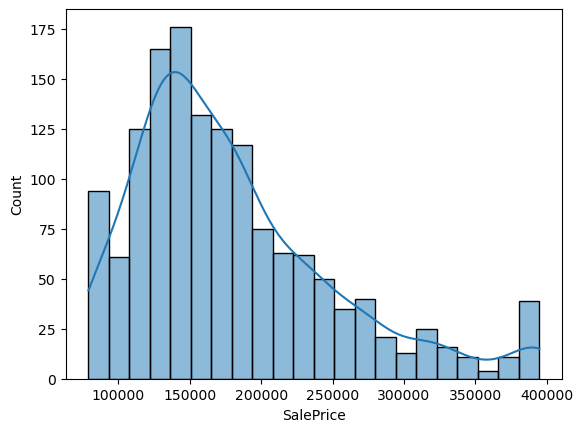

In [36]:
# Current distribution
sns.histplot(housing_au_df['SalePrice'], kde=True)
plt.show()

In [37]:
housing_au_df['SalePrice'].kurtosis()

1.0379355634303224

In [38]:
housing_au_df['SalePrice'].skew()

1.1353609015712187

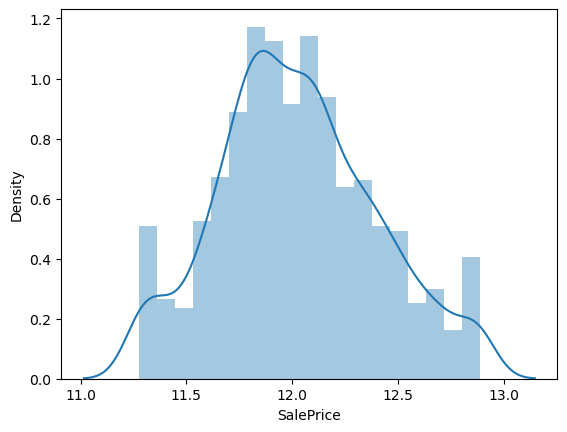

In [39]:
## We will utilize the np.log function to achieve normality
housing_au_df['SalePrice']= np.log(housing_au_df['SalePrice'])
sns.distplot(housing_au_df['SalePrice'], kde=True)
plt.show()

In [40]:
## Kurtosis is less than 1.
housing_au_df['SalePrice'].kurtosis()

-0.31658829317065695

In [41]:
## Skew is less than 1
housing_au_df['SalePrice'].skew()

0.23206852219522126

`Findings\Observations:` - Used `np.log` on `target_sales_price` to a normal distribution with skew (`0.23`) and kurtosis (`-0.32`) less 1. 

### Correlation Matrix


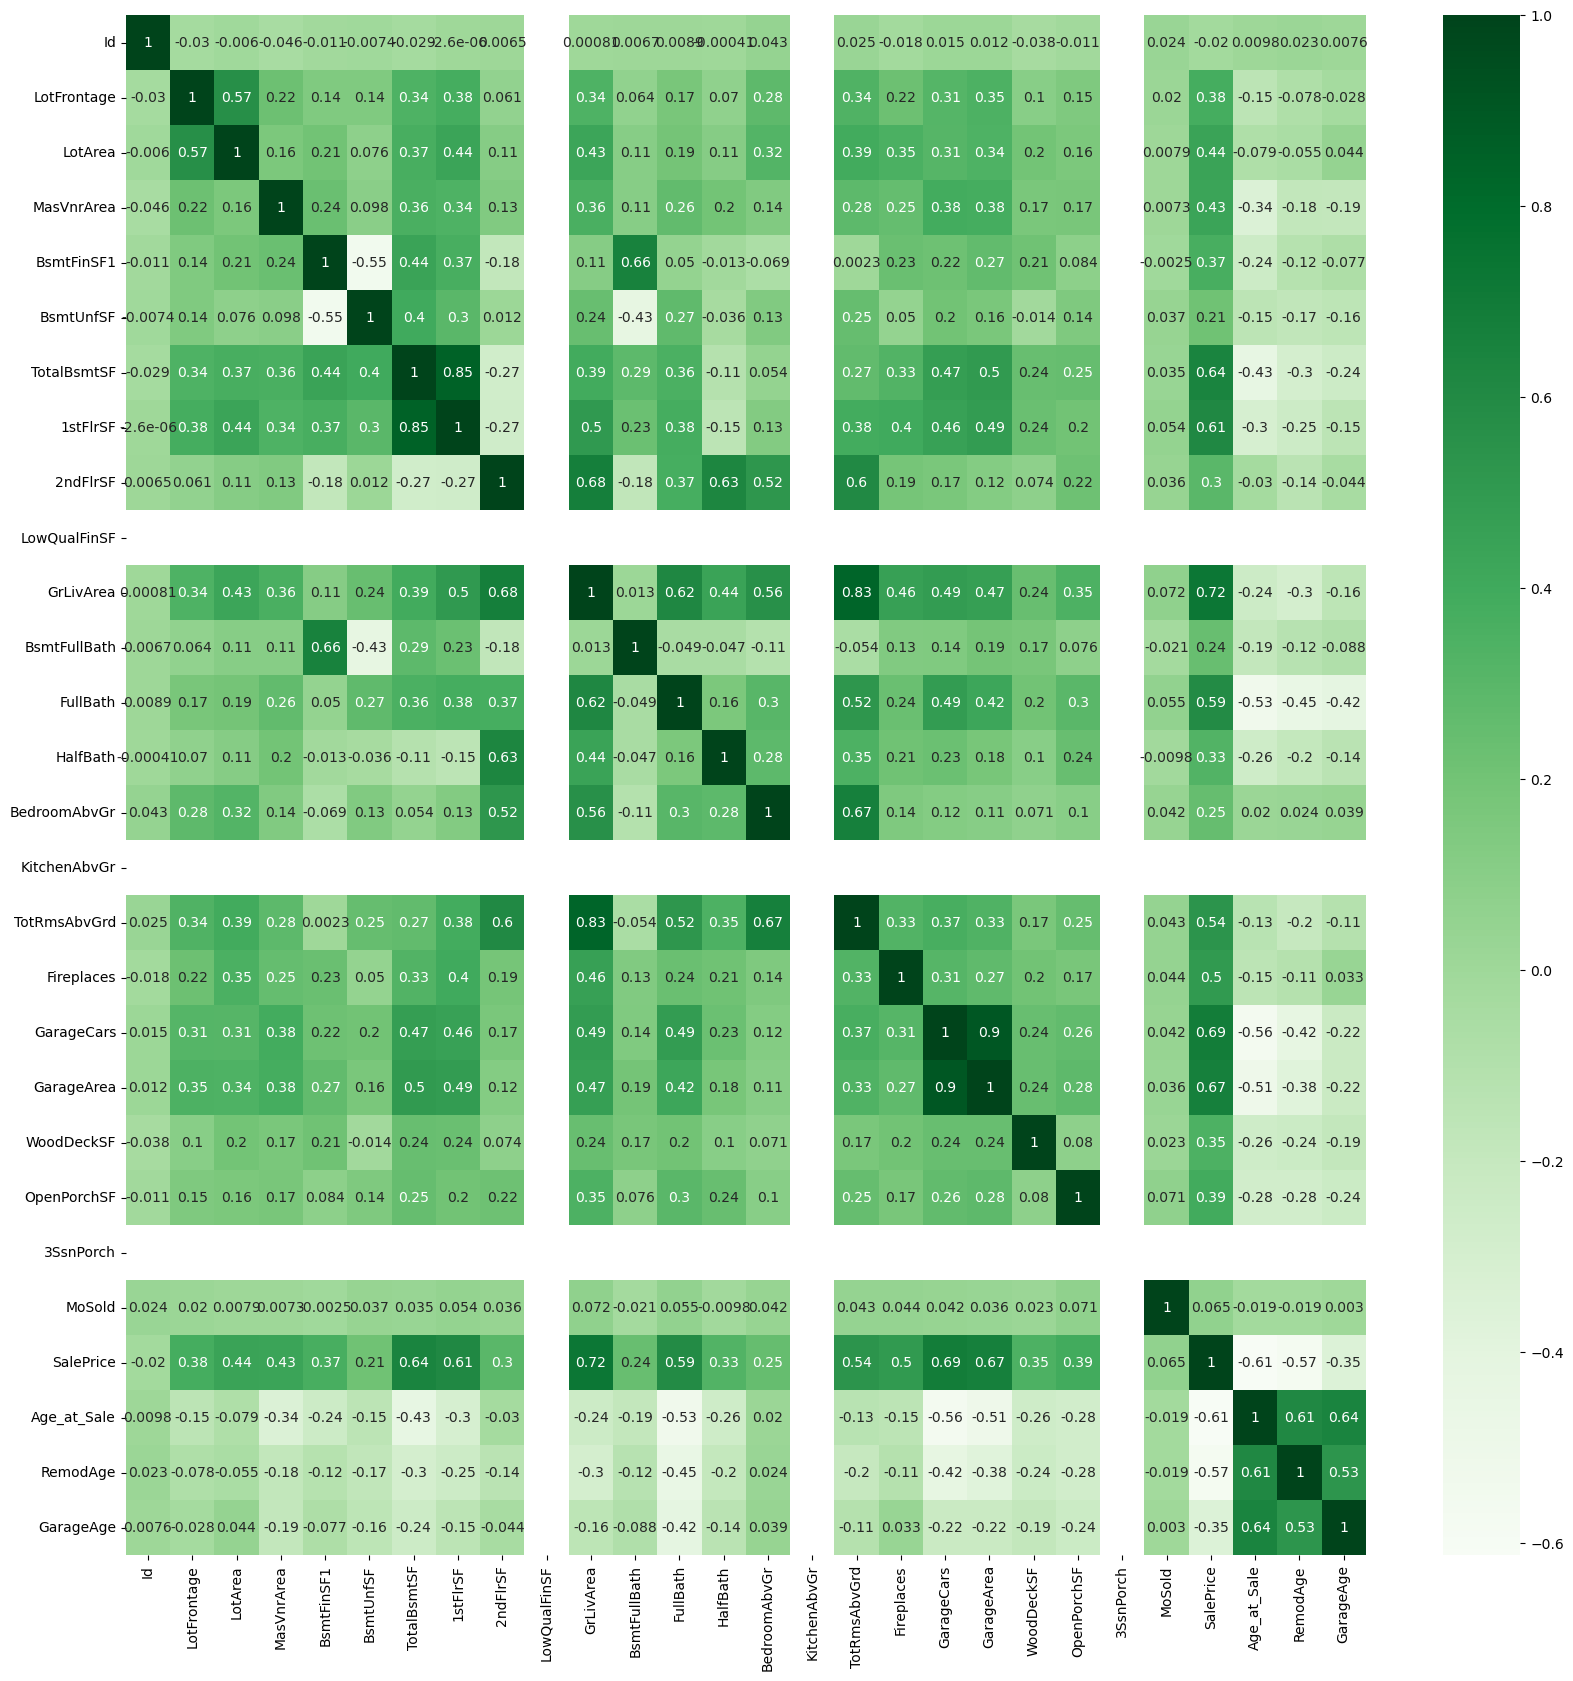

In [42]:
plt.figure(figsize=(20,20))
sns.heatmap(housing_au_df.corr(), cmap='Greens', annot=True)
plt.show()

### Dummy variables

In [43]:
## Create the dummy variables. 
housing_au_df_dummies = pd.get_dummies(housing_au_df.select_dtypes(include=['object']), drop_first=True)

## Concat with main dataframe
housing_au_df = pd.concat([housing_au_df, housing_au_df_dummies], axis=1)

## Drop the columns for which we have dummies
housing_au_df.drop(housing_au_df.select_dtypes(include=['object']).columns, axis=1, inplace=True)

In [44]:
housing_au_df.shape

(1460, 205)

`Findings/Observations`: After encoding all the categorical variables using dummy variables, we are 205 columns.

### Split into test-train

In [45]:
X = housing_au_df.drop(['Id', 'SalePrice'], axis=1)
y = housing_au_df.SalePrice

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size=0.3, random_state=100)

### Scaling 

In [47]:
## StandardScaler   
std_scaler = StandardScaler()
numerics = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerics] = std_scaler.fit_transform(X_train[numerics])
X_test[numerics] = std_scaler.fit_transform(X_test[numerics])
X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,-0.106787,-1.170115,-0.650325,0.082728,-0.373082,-0.552365,-0.862759,-0.808093,0.0,-1.419680,...,0,0,0,0,1,0,0,0,1,0
318,1.275349,0.073241,1.158620,1.341089,-0.458591,0.815810,0.637526,1.961881,0.0,2.170467,...,0,0,0,0,1,0,0,0,1,0
239,-1.008180,-0.262199,-0.650325,-0.824068,0.208848,-0.917778,-1.057678,0.864500,0.0,-0.023599,...,0,0,0,0,1,0,0,0,1,0
986,-0.587530,-1.255205,-0.650325,-1.051979,-0.161687,-1.528782,-0.458154,0.730984,0.0,0.308054,...,0,0,0,0,1,0,0,0,1,0
1416,-0.527437,0.490009,-0.650325,-1.051979,0.531878,-0.798806,0.265408,1.726285,0.0,1.775844,...,0,0,0,0,1,0,0,0,1,0


### Model Building

#### Routine to print model metrics

In [48]:
def print_metrics(eval_result):
    print("RSS (Training): {:.4f}".format(eval_result[0]))
    print("RSS (Test): {:.4f}".format(eval_result[1]))
    
    print("Training R-Squared: {:.4f}".format(eval_result[2]))
    print("Test R-Squared: {:.4f}".format(eval_result[3]))

    print("Training MSE: {:.4f}".format(eval_result[4]))
    print("Test MSE: {:.4f}".format(eval_result[5]))

    print("Training RMSE: {:.4f}".format(eval_result[6]))
    print("Testing RMSE: {:.4f}".format(eval_result[7]))

    return;

def eval_model(y_train, y_train_pred, y_test, y_pred):
    eval_result = []

    # RSS for training and test
    eval_result.append(np.sum(np.square(y_train - y_train_pred))) #0
    eval_result.append(np.sum(np.square(y_test - y_pred))) #1
    
    # R-squared scores for training and test models.
    eval_result.append(r2_score(y_train, y_train_pred)); #2
    eval_result.append(r2_score(y_test, y_pred)); #3
    
    # MSE for rtaining and test
    eval_result.append(mean_squared_error(y_train, y_train_pred)) #4
    eval_result.append(mean_squared_error(y_test, y_pred)) #5

    #RMSE for training and test
    eval_result.append(eval_result[4] ** 0.5) #6
    eval_result.append(eval_result[5] ** 0.5) #7

    print_metrics(eval_result)

    return eval_result;

#### Ridge Regression

In [49]:
alphas = {'alpha': [ 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100]}

ridge_reg = Ridge()
folds = 5;

# Cross validation 
ridge_CV = GridSearchCV(estimator=ridge_reg, 
                        param_grid=alphas, 
                        scoring=['neg_mean_absolute_error', 'r2'],
                        refit='r2',
                        cv= folds, 
                        return_train_score=True,
                        verbose=1, 
                        n_jobs=-1 # Use all processors
                        )
ridge_CV.fit(X_train, y_train);

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [50]:
pd.DataFrame(ridge_CV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.036110,0.002490,0.009739,0.001183,0.01,{'alpha': 0.01},-0.078111,-0.086065,-0.090407,-0.082001,...,0.899906,0.013926,23,0.946884,0.953868,0.953850,0.946762,0.946098,0.949493,0.003576
1,0.035890,0.013967,0.010463,0.001161,0.05,{'alpha': 0.05},-0.077778,-0.085679,-0.090046,-0.081294,...,0.901421,0.014408,22,0.946860,0.953834,0.953810,0.946732,0.946058,0.949459,0.003573
2,0.021832,0.001393,0.012252,0.001550,0.1,{'alpha': 0.1},-0.077424,-0.085304,-0.089717,-0.080653,...,0.902755,0.014882,20,0.946810,0.953768,0.953733,0.946681,0.945971,0.949393,0.003570
3,0.022746,0.002742,0.010443,0.000862,0.2,{'alpha': 0.2},-0.076917,-0.084720,-0.089248,-0.079688,...,0.904649,0.015608,19,0.946684,0.953621,0.953556,0.946560,0.945753,0.949235,0.003569
4,0.020133,0.001346,0.009102,0.000943,0.3,{'alpha': 0.3},-0.076455,-0.084319,-0.088950,-0.078905,...,0.906015,0.016151,18,0.946541,0.953470,0.953379,0.946427,0.945518,0.949067,0.003576
5,0.019297,0.002057,0.010793,0.003391,0.4,{'alpha': 0.4},-0.076063,-0.084052,-0.088796,-0.078230,...,0.907080,0.016574,17,0.946389,0.953320,0.953209,0.946289,0.945284,0.948898,0.003586
6,0.020926,0.002685,0.009345,0.001351,0.5,{'alpha': 0.5},-0.075693,-0.083819,-0.088676,-0.077636,...,0.907947,0.016914,16,0.946234,0.953170,0.953045,0.946149,0.945055,0.948731,0.003598
7,0.018920,0.001525,0.008694,0.001163,0.6,{'alpha': 0.6},-0.075346,-0.083610,-0.088583,-0.077108,...,0.908671,0.017194,15,0.946076,0.953021,0.952888,0.946009,0.944835,0.948566,0.003611
8,0.020427,0.002676,0.008939,0.000808,0.7,{'alpha': 0.7},-0.075026,-0.083420,-0.088497,-0.076670,...,0.909289,0.017427,14,0.945917,0.952874,0.952736,0.945870,0.944623,0.948404,0.003623
9,0.017626,0.000740,0.011522,0.004021,0.8,{'alpha': 0.8},-0.074755,-0.083247,-0.088416,-0.076345,...,0.909824,0.017626,13,0.945759,0.952728,0.952589,0.945733,0.944419,0.948245,0.003636


In [51]:
ridge_CV.best_params_

{'alpha': 6.0}

In [52]:
ridge_reg = Ridge(alpha= ridge_CV.best_params_['alpha'])
ridge_reg.fit(X_train, y_train)
ridge_metrics = eval_model(y_train, ridge_reg.predict(X_train), y_test, ridge_reg.predict(X_test))

RSS (Training): 8.4770
RSS (Test): 6.2901
Training R-Squared: 0.9405
Test R-Squared: 0.8975
Training MSE: 0.0083
Test MSE: 0.0144
Training RMSE: 0.0911
Testing RMSE: 0.1198


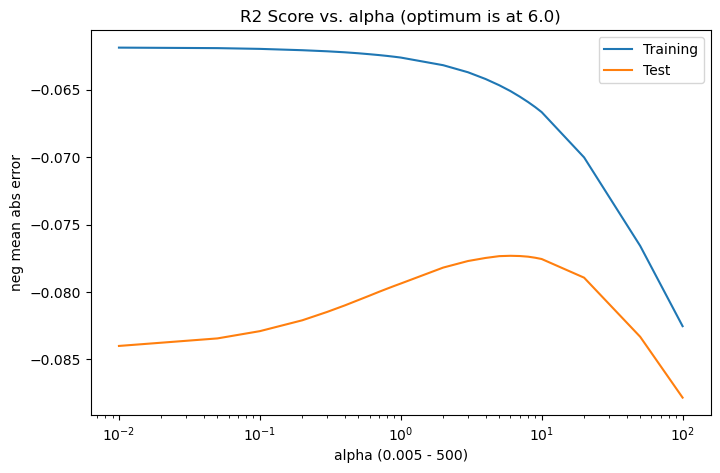

In [53]:
## Plot alpha against neg_mean_absolute_error
plt.figure(figsize=(8,5))
ridge_cv_res_df = pd.DataFrame(ridge_CV.cv_results_)
plt.title('R2 Score vs. alpha (optimum is at 6.0)')
plt.plot(ridge_cv_res_df['param_alpha'], ridge_cv_res_df['mean_train_neg_mean_absolute_error'], label='Training')
plt.plot(ridge_cv_res_df['param_alpha'], ridge_cv_res_df['mean_test_neg_mean_absolute_error'], label='Test')

plt.ylabel('neg mean abs error')
plt.xlabel('alpha (0.005 - 500)')
plt.xscale('log')
plt.legend()
plt.show()

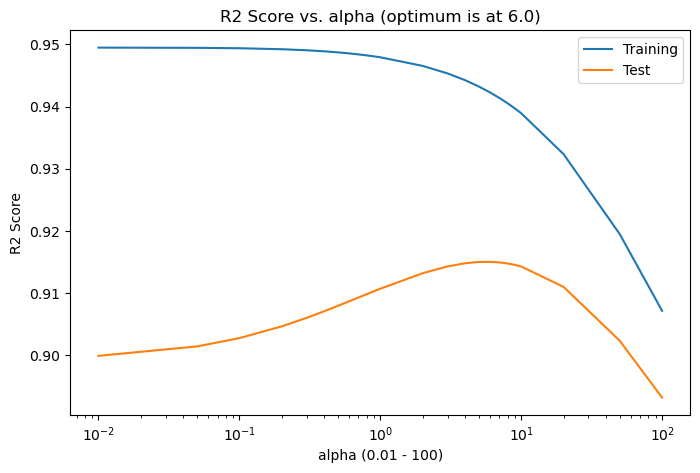

In [54]:
## Plot alpha against neg_mean_absolute_error
plt.figure(figsize=(8,5))
ridge_cv_res_df = pd.DataFrame(ridge_CV.cv_results_)
plt.title('R2 Score vs. alpha (optimum is at 6.0)')
plt.plot(ridge_cv_res_df['param_alpha'], ridge_cv_res_df['mean_train_r2'], label='Training')
plt.plot(ridge_cv_res_df['param_alpha'], ridge_cv_res_df['mean_test_r2'], label='Test')

plt.ylabel('R2 Score')
plt.xlabel('alpha (0.01 - 100)')
plt.xscale('log')
plt.legend()
plt.show()

In [55]:
# Coefficients from Ridge model with alpha = 6.0
ridge_reg.coef_

array([ 0.00587332,  0.02364828,  0.00146408,  0.01448452, -0.00933444,
        0.06242216, -0.00288437,  0.02795222,  0.        ,  0.09658247,
        0.01049766,  0.00947266,  0.0124529 , -0.00069094,  0.        ,
       -0.00070534,  0.00984437,  0.01423476,  0.02036243,  0.01070492,
        0.00666499,  0.        ,  0.00162066, -0.0615617 , -0.00120841,
       -0.00351961, -0.04583609, -0.02421066,  0.00094266,  0.00794016,
       -0.02211421,  0.04721204,  0.03433325, -0.00823185,  0.01206716,
       -0.03164841,  0.00059079, -0.04141149, -0.03886417, -0.02021626,
        0.05772605,  0.03786196,  0.02806306, -0.0080633 ,  0.01433682,
       -0.03715414,  0.00870002, -0.01066166,  0.03484141, -0.01986806,
       -0.00289946,  0.00823127,  0.00574581, -0.02413742,  0.02810171,
        0.0351112 , -0.00943961,  0.10336873, -0.07431098,  0.00239653,
       -0.00618474, -0.08012678, -0.04158592, -0.02944595,  0.00814872,
       -0.03977605,  0.04606659,  0.05528452, -0.04211655,  0.02

#### Lasso Regression

In [56]:
alphas = {'alpha': [ 0.0001, 0.005, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]}

lasso_reg = Lasso()

folds = 5;
lasso_CV = GridSearchCV(estimator=lasso_reg, 
                        param_grid=alphas,
                        scoring=['neg_mean_absolute_error', 'r2'],
                        refit='r2',
                        cv=folds,
                        return_train_score=True,
                        verbose=1
                        )
lasso_CV.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             refit='r2', return_train_score=True,
             scoring=['neg_mean_absolute_error', 'r2'], verbose=1)

In [57]:
lasso_cv_res_df = pd.DataFrame(lasso_CV.cv_results_)
lasso_cv_res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.029396,0.004372,0.005605,0.001832,0.0001,{'alpha': 0.0001},-0.073028,-0.082811,-0.087533,-0.076277,...,0.911985,0.018851,1,0.944795,0.951723,0.951398,0.944620,0.943227,0.947153,0.003641
1,0.018012,0.002971,0.008626,0.004270,0.005,{'alpha': 0.005},-0.085604,-0.104209,-0.102236,-0.098250,...,0.869032,0.022118,2,0.872899,0.883255,0.882850,0.877590,0.874665,0.878252,0.004198
2,0.012637,0.001252,0.006315,0.000819,0.01,{'alpha': 0.01},-0.089701,-0.109989,-0.107698,-0.101900,...,0.856267,0.023147,3,0.854801,0.866894,0.866454,0.860324,0.855680,0.860831,0.005129
3,0.011891,0.000995,0.005413,0.000864,0.05,{'alpha': 0.05},-0.112845,-0.137821,-0.126608,-0.126291,...,0.797733,0.020463,4,0.793752,0.806148,0.808413,0.803697,0.794132,0.801228,0.006135
4,0.011974,0.001380,0.005505,0.001093,0.1,{'alpha': 0.1},-0.152619,-0.176041,-0.157099,-0.165853,...,0.672975,0.022285,5,0.668723,0.677446,0.683588,0.682879,0.668815,0.676290,0.006498
5,0.010024,0.000898,0.004799,0.000752,0.2,{'alpha': 0.2},-0.231395,-0.249053,-0.223771,-0.230599,...,0.351051,0.027901,6,0.344965,0.351902,0.352131,0.374146,0.358093,0.356247,0.009868
6,0.009732,0.000989,0.004737,0.000677,0.3,{'alpha': 0.3},-0.236034,-0.250456,-0.228187,-0.238051,...,0.327118,0.021571,7,0.324513,0.339831,0.329667,0.329166,0.337224,0.332080,0.005623
7,0.009535,0.000908,0.004310,0.000403,0.4,{'alpha': 0.4},-0.236712,-0.249929,-0.228160,-0.238159,...,0.325899,0.021272,8,0.323316,0.338622,0.328485,0.328001,0.336029,0.330891,0.005616
8,0.009516,0.001309,0.003708,0.000681,0.5,{'alpha': 0.5},-0.237575,-0.249441,-0.228135,-0.238420,...,0.324339,0.020959,9,0.321778,0.337069,0.326965,0.326503,0.334494,0.329362,0.005607
9,0.010617,0.001205,0.005127,0.001594,0.6,{'alpha': 0.6},-0.238569,-0.249222,-0.228110,-0.238817,...,0.322436,0.020632,10,0.319898,0.335170,0.325107,0.324672,0.332617,0.327493,0.005595


In [58]:
lasso_reg = Lasso(lasso_CV.best_params_['alpha'])
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [59]:
lasso_metrics = eval_model(y_train, lasso_reg.predict(X_train), y_test, lasso_reg.predict(X_test))

RSS (Training): 8.0312
RSS (Test): 6.4541
Training R-Squared: 0.9437
Test R-Squared: 0.8949
Training MSE: 0.0079
Test MSE: 0.0147
Training RMSE: 0.0887
Testing RMSE: 0.1214


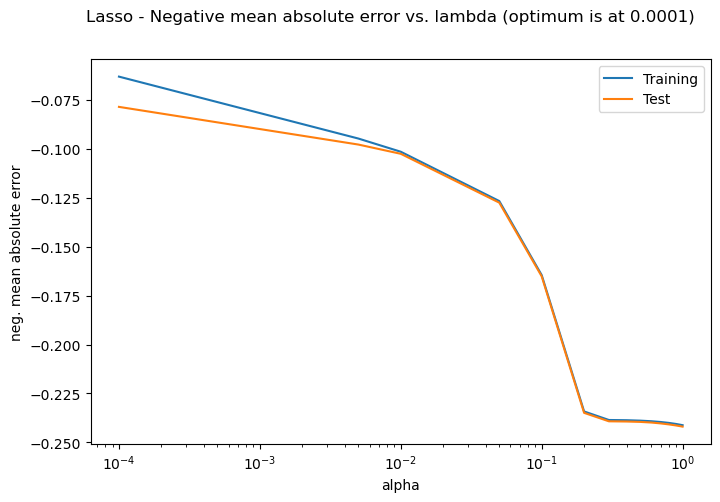

In [60]:
# Plot against negative mean absolute error.
plt.figure(figsize=(8,5))
lasso_cv_res_df = pd.DataFrame(lasso_CV.cv_results_)
plt.suptitle('Lasso - Negative mean absolute error vs. lambda (optimum is at {0})'.format(lasso_CV.best_params_['alpha']))
plt.plot(lasso_cv_res_df['param_alpha'], lasso_cv_res_df['mean_train_neg_mean_absolute_error'], label='Training')
plt.plot(lasso_cv_res_df['param_alpha'], lasso_cv_res_df['mean_test_neg_mean_absolute_error'], label='Test')
plt.ylabel('neg. mean absolute error')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend()
plt.show()

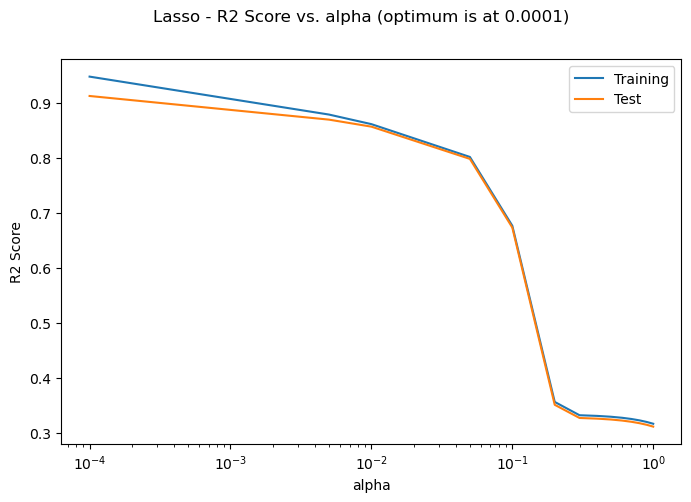

In [61]:
## Plot alpha against R2 
plt.figure(figsize=(8,5))
lasso_cv_res_df = pd.DataFrame(lasso_CV.cv_results_)
plt.suptitle('Lasso - R2 Score vs. alpha (optimum is at {0})'.format(lasso_CV.best_params_['alpha']))
plt.plot(lasso_cv_res_df['param_alpha'], lasso_cv_res_df['mean_train_r2'], label='Training')
plt.plot(lasso_cv_res_df['param_alpha'], lasso_cv_res_df['mean_test_r2'], label='Test')

plt.ylabel('R2 Score')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend()
plt.show()

In [62]:
lasso_reg.coef_

array([ 4.75877028e-03,  2.47814059e-02, -9.20118403e-04,  1.14064993e-02,
       -9.48753236e-03,  6.42552774e-02, -1.46913862e-02,  1.24517086e-02,
        0.00000000e+00,  1.10172970e-01,  1.14969857e-02,  1.02391910e-02,
        1.32401599e-02, -5.49197220e-04,  0.00000000e+00, -1.57164939e-03,
        4.47102191e-03,  1.43123311e-02,  2.00290891e-02,  1.04323782e-02,
        5.89762487e-03,  0.00000000e+00,  1.68735975e-03, -6.75738512e-02,
       -9.95844738e-04, -4.88961947e-04, -5.15737491e-02, -5.14053828e-02,
       -0.00000000e+00,  5.85381430e-03, -2.63787138e-02,  3.35913595e-02,
        4.41776864e-02, -0.00000000e+00,  0.00000000e+00, -5.71712289e-02,
       -9.50880610e-03, -6.20002781e-02, -3.74607559e-02, -4.96053153e-02,
        9.98434853e-02,  8.30502959e-02,  5.64331607e-02,  2.70110485e-02,
        1.24774676e-02, -3.84952848e-02,  1.10752734e-02, -0.00000000e+00,
        3.41053111e-02, -2.23787820e-02, -0.00000000e+00,  6.84254021e-03,
        0.00000000e+00, -

#### Comparision Ridge vs. Lasso

In [63]:
print("Ridge")
print_metrics(ridge_metrics)
print("\nLasso")
print_metrics(lasso_metrics)

Ridge
RSS (Training): 8.4770
RSS (Test): 6.2901
Training R-Squared: 0.9405
Test R-Squared: 0.8975
Training MSE: 0.0083
Test MSE: 0.0144
Training RMSE: 0.0911
Testing RMSE: 0.1198

Lasso
RSS (Training): 8.0312
RSS (Test): 6.4541
Training R-Squared: 0.9437
Test R-Squared: 0.8949
Training MSE: 0.0079
Test MSE: 0.0147
Training RMSE: 0.0887
Testing RMSE: 0.1214


In [64]:
# Comparing coefficients
coefficients = pd.DataFrame(index=X_train.columns)
coefficients.rows = X_train.columns
coefficients['ridge'] = ridge_reg.coef_
coefficients['lasso'] = lasso_reg.coef_
coefficients

,ridge,lasso
LotFrontage,0.005873,0.004759
LotArea,0.023648,0.024781
MasVnrArea,0.001464,-0.000920
BsmtFinSF1,0.014485,0.011406
BsmtUnfSF,-0.009334,-0.009488
...,...,...
SaleCondition_AdjLand,0.027661,0.075262
SaleCondition_Alloca,0.050176,0.090290
SaleCondition_Family,0.012273,0.023811
SaleCondition_Normal,0.041489,0.045872


In [65]:
coefficients[coefficients['lasso']==0]

,ridge,lasso
LowQualFinSF,0.000000,0.0
KitchenAbvGr,0.000000,0.0
3SsnPorch,0.000000,0.0
MSSubClass_45,0.000943,-0.0
MSSubClass_80,-0.008232,-0.0
MSSubClass_85,0.012067,0.0
Utilities_NoSeWa,-0.010662,-0.0
LotConfig_FR3,-0.002899,-0.0
Neighborhood_Blueste,0.005746,0.0
Neighborhood_CollgCr,-0.009440,-0.0


`173` features out of `205` removed by lasso regression.

In [66]:
# features picked by lasso
coefficients.loc[coefficients['lasso']!=0, 'lasso']

LotFrontage              0.004759
LotArea                  0.024781
MasVnrArea              -0.000920
BsmtFinSF1               0.011406
BsmtUnfSF               -0.009488
                           ...   
SaleCondition_AdjLand    0.075262
SaleCondition_Alloca     0.090290
SaleCondition_Family     0.023811
SaleCondition_Normal     0.045872
SaleCondition_Partial    0.038352
Name: lasso, Length: 152, dtype: float64

### Top 10 features from Ridge for lambda 6.0

In [67]:
# Top 10 features from Ridge, lamdba 6.0
coefficients['ridge'].sort_values(ascending=False)[:10]

OverallQual_9           0.130398
OverallCond_9           0.114845
Neighborhood_Crawfor    0.103369
GrLivArea               0.096582
OverallQual_8           0.087623
Neighborhood_StoneBr    0.074908
Exterior1st_BrkFace     0.067385
TotalBsmtSF             0.062422
OverallCond_7           0.062241
MSZoning_FV             0.057726
Name: ridge, dtype: float64

### Top 10 features from Lasso for lambda 0.0001

In [68]:
# Top 10 features from lasso, lambda = 0.0001
coefficients['lasso'].sort_values(ascending=False)[:10]

OverallCond_9           0.218637
OverallQual_9           0.200468
SaleType_ConLD          0.129059
Neighborhood_Crawfor    0.123190
OverallQual_8           0.118756
Neighborhood_StoneBr    0.116847
GrLivArea               0.110173
OverallCond_8           0.104088
OverallCond_7           0.102920
MSZoning_FV             0.099843
Name: lasso, dtype: float64

## Work related to subjective questions

### Effects of doubling the lambda value

In [69]:
ridge_reg_2x = Ridge(ridge_CV.best_params_['alpha'] * 2)
ridge_reg_2x.fit(X_train, y_train)
eval_model(y_train, ridge_reg_2x.predict(X_train), y_test, ridge_reg_2x.predict(X_test))

RSS (Training): 9.0344
RSS (Test): 6.3872
Training R-Squared: 0.9366
Test R-Squared: 0.8960
Training MSE: 0.0088
Test MSE: 0.0146
Training RMSE: 0.0941
Testing RMSE: 0.1208


[9.034403410492699,
 6.387205476315801,
 0.936625210480892,
 0.89596180852817,
 0.008848583164047697,
 0.014582660904830595,
 0.09406690791159077,
 0.12075868873431259]

In [70]:
lasso_reg_2x = Lasso(lasso_CV.best_params_['alpha'] * 2)
lasso_reg_2x.fit(X_train, y_train)
eval_model(y_train, lasso_reg_2x.predict(X_train), y_test, lasso_reg_2x.predict(X_test))

RSS (Training): 8.3493
RSS (Test): 6.3004
Training R-Squared: 0.9414
Test R-Squared: 0.8974
Training MSE: 0.0082
Test MSE: 0.0144
Training RMSE: 0.0904
Testing RMSE: 0.1199


[8.349299487149187,
 6.300353637623781,
 0.9414310969315881,
 0.8973764973552364,
 0.008177570506512426,
 0.014384369035670733,
 0.09042992041637782,
 0.11993485329824159]

In [71]:
coefficients['lasso_2x_lambda'] = lasso_reg_2x.coef_
coefficients['ridge_2x_lambda'] = ridge_reg_2x.coef_
coefficients['ridge_2x_lambda'].sort_values(ascending=False)[:10]

OverallQual_9           0.105803
GrLivArea               0.089565
Neighborhood_Crawfor    0.089380
OverallCond_9           0.080461
OverallQual_8           0.079830
TotalBsmtSF             0.060841
Exterior1st_BrkFace     0.057032
OverallCond_7           0.056596
Neighborhood_StoneBr    0.053598
CentralAir_Y            0.050557
Name: ridge_2x_lambda, dtype: float64

In [72]:
coefficients['lasso_2x_lambda'].sort_values(ascending=False)[:10]

OverallCond_9           0.205079
OverallQual_9           0.198687
Neighborhood_Crawfor    0.120103
OverallQual_8           0.120058
GrLivArea               0.106497
OverallCond_7           0.100082
OverallCond_8           0.099157
Neighborhood_StoneBr    0.096573
Exterior1st_BrkFace     0.084060
SaleType_ConLD          0.071804
Name: lasso_2x_lambda, dtype: float64

### Effects of dropping top 5 features from Lasso

In [73]:
# Dropping ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF'] from X_train and refitting.
X_train.drop(coefficients['lasso'][:5].index.to_list(), axis=1, inplace=True)
lasso_top5_dropped = Lasso(alpha=lasso_CV.best_params_['alpha'])
lasso_top5_dropped.fit(X_train, y_train)



Lasso(alpha=0.0001)

In [74]:
new_coefficients = pd.DataFrame(index=X_train.columns)
new_coefficients.rows = X_train.columns
new_coefficients['lasso_top5_dropped'] = lasso_top5_dropped.coef_
new_coefficients['lasso_top5_dropped'].sort_values(ascending=False)[:5]

OverallCond_9           0.217272
OverallQual_9           0.203869
Neighborhood_Crawfor    0.132758
SaleType_ConLD          0.129297
OverallQual_8           0.120210
Name: lasso_top5_dropped, dtype: float64